## Table of Contents

- [Prework](#Prework)
    - [Comparison between IV and HV](#Comparison_between_IV_and_HV)
    - [Visualisaton for IV and HV](#Visualisaton_for_IV_and_HV)
        - [Summary statistics](#Summary_statistics)
        - [Data visualization](#Data_visualization)
        - [Stationarity check](#Stationarity_check)
        - [Performance metrics](#Performance_metrics)

- [Build Model](#Build_Model)
    - [Split trainning and testing dataset using VIX](#Split_trainning_and_testing_dataset_using_VIX)
    - [Benchmark - Multi-Layer Perceptron (MLP)](#Benchmark_Multi-Layer_Perceptron_(MLP))
    - [Build the ARIMA model using IV](#Build_the_ARIMA_model_using_IV)
    - [Build the GARCH model using HV](#Build_the_GARCH_model_using_HV)
    - [Build ANN model - LSTM](#Build_ANN_model_LSTM)
    - [Build ANN model - GRU](#Build_ANN_model_GRU)
    - [Build LSTM-ARIMA model](#Build_LSTM-ARIMA_model)
    - [Build ARIMA-LSTM model](#Build_ARIMA-LSTM_model)
    - [Build GRU-ARIMA model](#Build_GRU-ARIMA_model)
    - [Build ARIMA-GRU model](#Build_ARIMA-GRU_model)

- [Strategies](#Strategies)
    - [Combine models prediction results](#Combine_models_prediction_results)
    - [Evaluation method 1: index metrics](#Evaluation_method_1_index_metrics)
    - [Evaluation method 2: trading strategies](#Evaluation_method_2_trading_strategies)
    - [Evaluation method 3: Option pricing](#Evaluation_method_3_Option_pricing)
        - [Call option](#Call_option)
        - [Put option](#Put_option)


## Prework

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
from scipy.optimize import minimize
from keras.layers.core import Dense, Activation, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.descriptivestats import describe
from statsmodels.tsa.stattools import adfuller as adf
import tensorflow as tf
import random as rn
import os
from scipy.stats import norm
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import arch
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import GridSearchCV
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import math
from scipy.stats import norm
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
#Import data from downloaded excel files
VIX = pd.read_excel("VIX.xlsx",index_col = "Date")
SP500 = pd.read_excel("S&P500.xlsx",index_col = "Date")

### Comparison_between_IV_and_HV

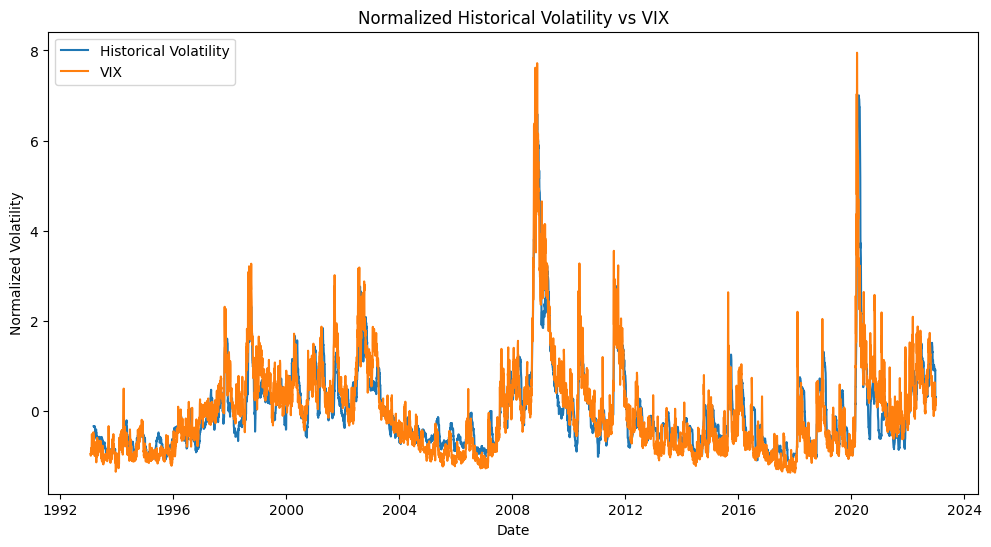

In [3]:
common_index = SP500.index.intersection(VIX.index)
vix_sub_df = VIX.loc[common_index]
# Calculate the historical volatility from the SP500 dataframe
window_size = 30  # Adjust the window size as desired
sp500_returns = SP500['Return'] # Calculate the daily returns
historical_volatility = sp500_returns.rolling(window_size).std()  # Calculate rolling standard deviation

# Normalize the data
historical_volatility_normalized = (historical_volatility - historical_volatility.mean()) / historical_volatility.std()
vix_normalized = (vix_sub_df['CBOE S&P500 Volatility Index - Close'] - vix_sub_df['CBOE S&P500 Volatility Index - Close'].mean()) / vix_sub_df['CBOE S&P500 Volatility Index - Close'].std()

# Plot the normalized historical volatility and VIX data
plt.figure(figsize=(12, 6))
plt.plot(historical_volatility_normalized, label='Historical Volatility')
plt.plot(vix_normalized, label='VIX')
plt.xlabel('Date')
plt.ylabel('Normalized Volatility')
plt.title('Normalized Historical Volatility vs VIX')
plt.legend()
plt.show()

### Visualisaton_for_IV_and_HV

#### Summary_statistics

In [4]:
print(VIX['CBOE S&P500 Volatility Index - Close'].describe())

count    11888.000000
mean        19.827030
std          7.558639
min          9.140000
25%         14.220000
50%         18.430000
75%         23.402500
max         82.690000
Name: CBOE S&P500 Volatility Index - Close, dtype: float64


#### Data_visualization

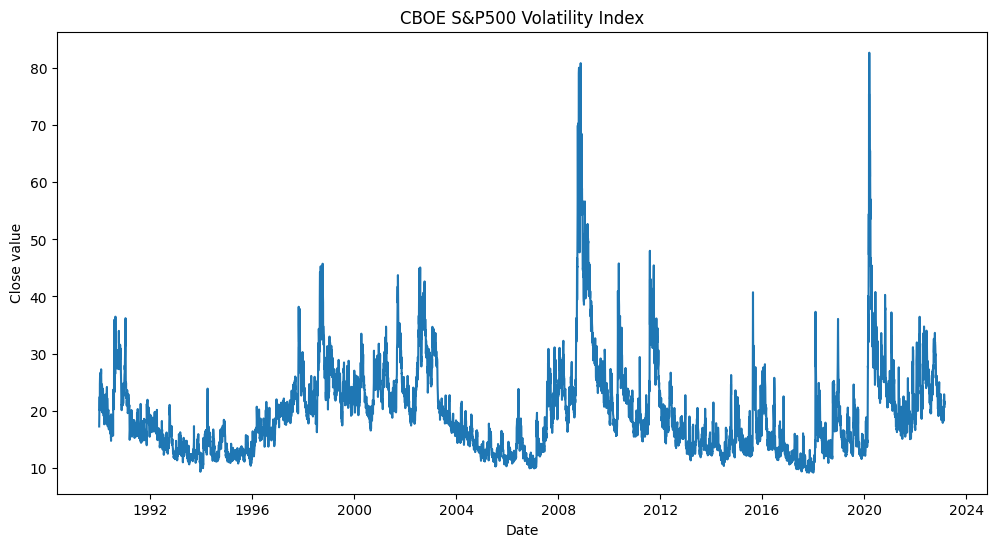

In [5]:
plt.figure(figsize=(12, 6))
# Create a line plot of the VIX close price
plt.plot(VIX.index, VIX['CBOE S&P500 Volatility Index - Close'])

# Set the title and axis labels
plt.title('CBOE S&P500 Volatility Index')
plt.xlabel('Date')
plt.ylabel('Close value')

# Display the plot
plt.show()

#### Stationarity_check

In [6]:
VIX_close = VIX['CBOE S&P500 Volatility Index - Close'].dropna()

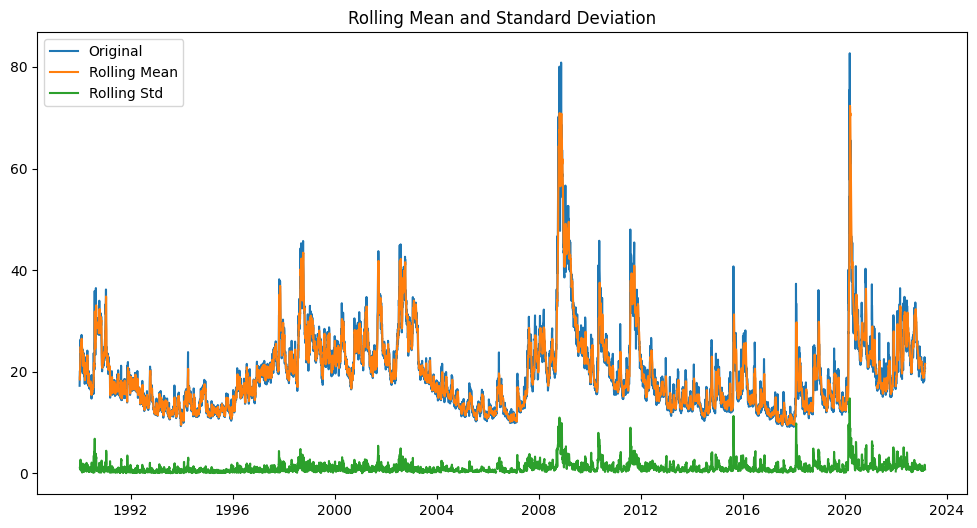

ADF Test Results:
ADF Statistic: -6.435875331088846
p-value: 1.6534181247177776e-08
Critical Values:
   1%: -3.4309020990516372
   5%: -2.8617839991285003
   10%: -2.56689987567371
KPSS Test Results:
KPSS Statistic: 0.9088755209767472
p-value: 0.01
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739


C:\Users\10718\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [7]:
from statsmodels.tsa.stattools import adfuller, kpss

# Plot rolling mean and standard deviation
def plot_rolling_statistics(timeseries, window=7):
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()
    
    plt.figure(figsize=(12, 6))
    plt.plot(timeseries, label='Original')
    plt.plot(rolmean, label='Rolling Mean')
    plt.plot(rolstd, label='Rolling Std')
    plt.legend()
    plt.title('Rolling Mean and Standard Deviation')
    plt.show()

# Augmented Dickey-Fuller test
def adf_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print("ADF Test Results:")
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

# Kwiatkowski-Phillips-Schmidt-Shin test
def kpss_test(timeseries):
    result = kpss(timeseries, regression='c')
    print("KPSS Test Results:")
    print(f'KPSS Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values:')
    for key, value in result[3].items():
        print(f'   {key}: {value}')

# Check stationarity by plotting rolling statistics and conducting tests
plot_rolling_statistics(VIX['CBOE S&P500 Volatility Index - Close'])

adf_test(VIX_close)

kpss_test(VIX_close)


#### Performance_metrics

In [8]:
# Calculate performance metrics
def evaluation(test_data, model_predictions):
    mse = mean_squared_error(test_data, model_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_data, model_predictions)
    r2 = r2_score(test_data, model_predictions)

    print("Performance Metrics:")
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("Mean Absolute Error (MAE):", mae)
    print("R-squared (R^2) Score:", r2)

## Build_Model

### Split_trainning_and_testing_dataset_using_VIX

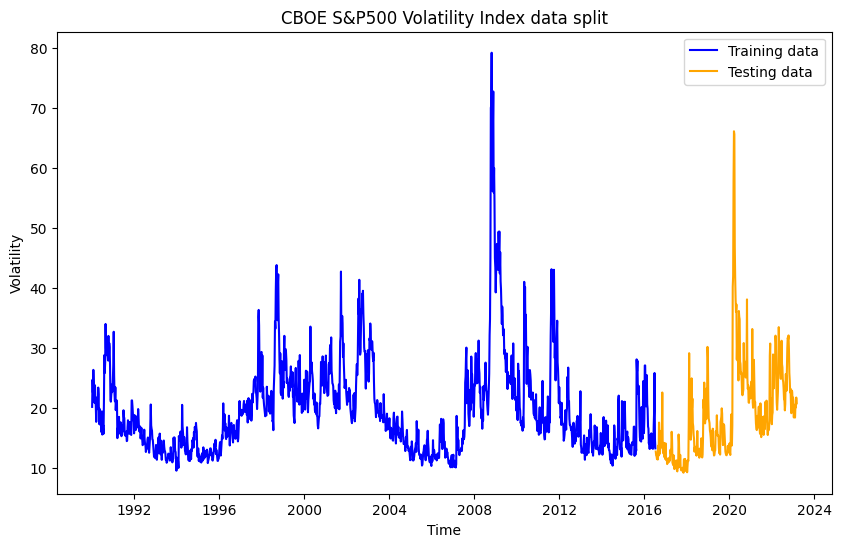

In [9]:
# Convert to the weekly dataset 
volatility_data = VIX['CBOE S&P500 Volatility Index - Close'].dropna().resample("W").last()

# Split the data into training, validation and test sets
train_size = int(len(volatility_data)*0.8)
test_size = len(volatility_data) - train_size

train_data = volatility_data[:train_size]
test_data = volatility_data[train_size:]
train_dates = train_data.index
test_dates = test_data.index

# Plot the data
plt.figure(figsize=(10,6))
plt.plot(train_data, label="Training data", color="blue")
plt.plot(test_data, label="Testing data", color="orange")
plt.title("CBOE S&P500 Volatility Index data split")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()
plt.show()

### Benchmark_Multi-Layer_Perceptron_(MLP)

In [10]:
# Normalize the data
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(train_data.values.reshape(-1, 1))

# Prepare the training data
lookback = 60  # Number of previous time steps to consider
X_train = []
y_train = []

for i in range(lookback, len(train_data_normalized)):
    X_train.append(train_data_normalized[i - lookback:i, 0])
    y_train.append(train_data_normalized[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the input data for LSTM (batch_size, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))

# Build the MLP model
model_mlp = Sequential()
model_mlp.add(Dense(units=64, activation='relu', input_shape=(X_train.shape[1],)))
model_mlp.add(Dense(units=32, activation='relu'))
model_mlp.add(Dense(units=1))
model_mlp.compile(optimizer='adam', loss='mean_squared_error')

# Train the MLP model
model_mlp.fit(X_train, y_train, epochs=10, batch_size=32)

# Prepare the test data
test_data_normalized = scaler.transform(test_data.values.reshape(-1, 1))

X_test = []
y_test = []

for i in range(lookback, len(test_data_normalized)):
    X_test.append(test_data_normalized[i - lookback:i, 0])
    y_test.append(test_data_normalized[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape the input data for MLP (batch_size, timesteps, features)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))

# Make predictions on the test data
predicted_values_mlp = model_mlp.predict(X_test)
predicted_values_mlp = scaler.inverse_transform(predicted_values_mlp)


Epoch 1/10
42/42 [==============================] - 1s 3ms/step - loss: 0.0094
Epoch 2/10
42/42 [==============================] - 0s 2ms/step - loss: 0.0042
Epoch 3/10
42/42 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 4/10
42/42 [==============================] - 0s 3ms/step - loss: 0.0026
Epoch 5/10
42/42 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 6/10
42/42 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 7/10
42/42 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 8/10
42/42 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 9/10
42/42 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 10/10
9/9 [==============================] - 0s 3ms/step


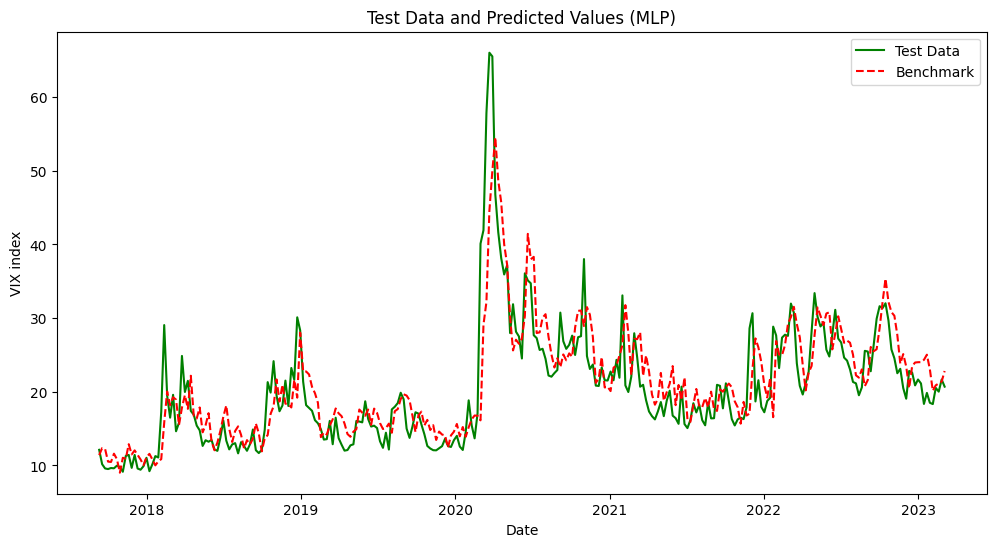

In [11]:
# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(test_dates[lookback:], test_data[lookback:], color='green', label='Test Data')
plt.plot(test_dates[lookback:], predicted_values_mlp, color='red', linestyle='dashed', label='Benchmark')
plt.title('Test Data and Predicted Values (MLP)')
plt.xlabel('Date')
plt.ylabel('VIX index')
plt.legend()
plt.show()

### Build_the_ARIMA_model_using_IV

Build a GARCH(1,1) model, and use the model to calculate fitted and predicted volatility of SP500 index. Plot the graph for original historical volatility and the predicted value, for the predicted value, use different color to show the fitted and predicted datasets.

In [12]:
# Train AutoARIMA model
model = auto_arima(train_data, trace=True, error_action='ignore', suppress_warnings=True)
# Fit the model
model.fit(train_data)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6757.410, Time=1.84 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6828.703, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6782.448, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6781.823, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6826.707, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6782.757, Time=0.77 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6756.554, Time=0.99 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6783.818, Time=0.39 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6784.167, Time=0.28 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=6757.625, Time=1.49 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=6782.706, Time=0.37 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=6757.464, Time=2.25 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=6754.596, Time=0.50 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6781.825, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]          

ARIMA(order=(2, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [13]:
history = [x for x in train_data]
predicted_values_arima = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(2,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predicted_values_arima.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)


C:\Users\10718\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\10718\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


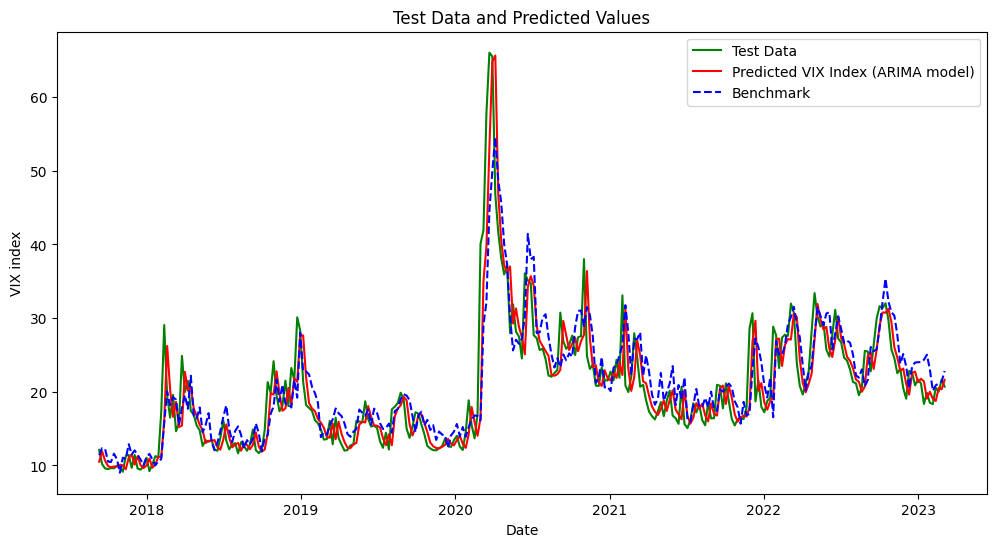

In [14]:
# Plot the graph
plt.figure(figsize=(12, 6))

# Plot the test data with a solid green line
plt.plot(test_dates[60:], test_data[60:], color='green', label='Test Data', linestyle='-')

# Plot the predicted values from the ARIMA model with a dashed red line
plt.plot(test_dates[60:], predicted_values_arima[60:], color='red', linestyle='-', label='Predicted VIX Index (ARIMA model)')

# Plot the predicted values from the MLP model with a dash-dot blue line
plt.plot(test_dates[60:], predicted_values_mlp, color='blue', linestyle='--', label='Benchmark')

plt.title('Test Data and Predicted Values')
plt.xlabel('Date')
plt.ylabel('VIX index')

# Move the legend outside the plot area to avoid overlapping the lines
plt.legend()

plt.show()


In [15]:
evaluation(test_data, predicted_values_arima)

Performance Metrics:
Mean Squared Error (MSE): 13.107733884921545
Root Mean Squared Error (RMSE): 3.6204604520587633
Mean Absolute Error (MAE): 2.2476284001140896
R-squared (R^2) Score: 0.7995063032798607


### Build_the_GARCH_model_using_HV

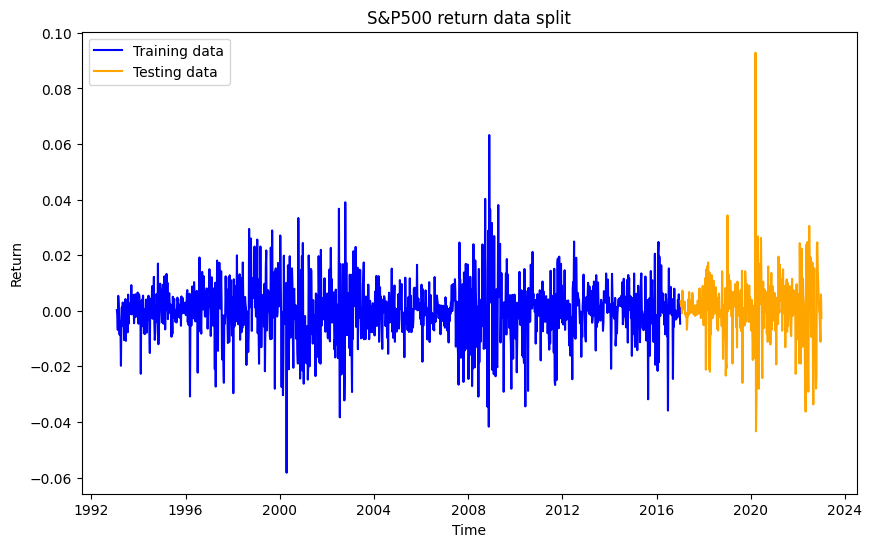

In [16]:
#Split train and test data using sp500 return data
sp500_data = sp500_returns.dropna().resample("W").last()
# Split the data into training, validation and test sets
train2_size = int(len(sp500_data)*0.8)
test2_size = len(sp500_data) - train2_size

train2_data = sp500_data[:train2_size]
test2_data = sp500_data[train2_size:]
train2_dates = train2_data.index
test2_dates = test2_data.index

# Plot the data
plt.figure(figsize=(10,6))
plt.plot(train2_data, label="Training data", color="blue")
plt.plot(test2_data, label="Testing data", color="orange")
plt.title("S&P500 return data split")
plt.xlabel("Time")
plt.ylabel("Return")
plt.legend()
plt.show()

C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001183. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001183. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: Data

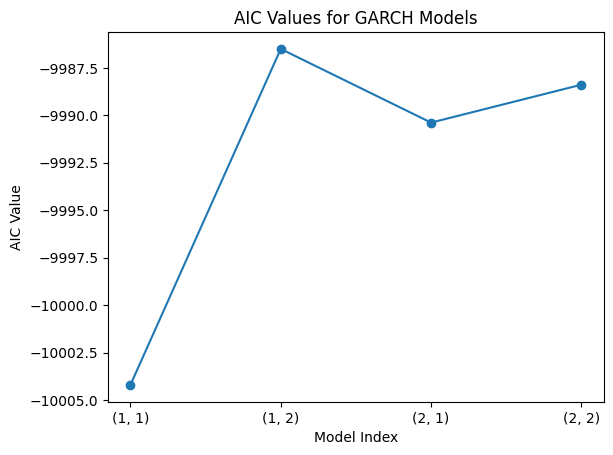

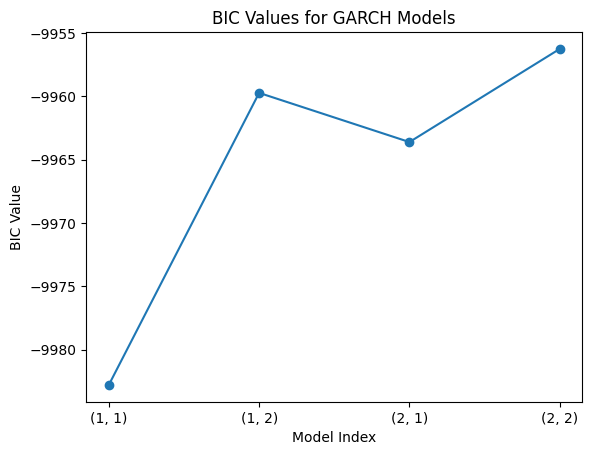

In [17]:
# Define the range of p and q values to consider
p_values = range(1, 3)  # Change the range as per your preference
q_values = range(1, 3)  # Change the range as per your preference

# Initialize lists to store AIC and BIC values
aic_values = []
bic_values = []
model_indices = []

# Iterate over different p and q values
for p in p_values:
    for q in q_values:
        model = arch.arch_model(sp500_data, vol='Garch', p=p, q=q)
        model_fit = model.fit(disp='off')
        aic_values.append(model_fit.aic)
        bic_values.append(model_fit.bic)
        model_indices.append((p, q))

# Plot AIC values
plt.plot(range(len(aic_values)), aic_values, marker='o')
plt.xlabel('Model Index')
plt.ylabel('AIC Value')
plt.title('AIC Values for GARCH Models')
plt.xticks(range(len(aic_values)), model_indices)
plt.show()

# Plot BIC values
plt.plot(range(len(bic_values)), bic_values, marker='o')
plt.xlabel('Model Index')
plt.ylabel('BIC Value')
plt.title('BIC Values for GARCH Models')
plt.xticks(range(len(bic_values)), model_indices)
plt.show()

In [18]:
history = [x for x in train2_data]
predicted_values_garch = []
N_test_observations = len(test2_data)
for time_point in range(N_test_observations):
    model = arch.arch_model(history, vol='Garch', p=1, q=1)
    model_fit = model.fit()
    output = model_fit.forecast().variance.values[-1]
    yhat = np.sqrt(output[0])
    predicted_values_garch.append(yhat)
    true_test_value = test2_data[time_point]
    history.append(true_test_value)

C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001108. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the opt

Iteration:      1,   Func. Count:      6,   Neg. LLF: 6.74375166909902e+19
Iteration:      2,   Func. Count:     18,   Neg. LLF: 3.762661773644279e+19
Iteration:      3,   Func. Count:     30,   Neg. LLF: 8112219420409364.0
Iteration:      4,   Func. Count:     45,   Neg. LLF: 2.3153703407214075e+18
Iteration:      5,   Func. Count:     57,   Neg. LLF: 1880685091060172.2
Iteration:      6,   Func. Count:     72,   Neg. LLF: 145293403.5811851
Iteration:      7,   Func. Count:     84,   Neg. LLF: 1.8429000178424328e+18
Iteration:      8,   Func. Count:     95,   Neg. LLF: -4033.8383111320563
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4033.838306582942
            Iterations: 12
            Function evaluations: 95
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      6,   Neg. LLF: 6.656541384638788e+19
Iteration:      2,   Func. Count:     18,   Neg. LLF: 3.6698483412263674e+19
Iteration:      3,   Func. Count:     30,

C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001103. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:      4,   Func. Count:     45,   Neg. LLF: 2.6966245065142224e+16
Iteration:      5,   Func. Count:     57,   Neg. LLF: -4078.437013954772
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4078.437009952049
            Iterations: 9
            Function evaluations: 57
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2137153095.3547783
Iteration:      2,   Func. Count:     18,   Neg. LLF: -4082.7152219830264
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4082.7152180519397
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      6,   Neg. LLF: 4.416091870645159e+19
Iteration:      2,   Func. Count:     19,   Neg. LLF: 2253.7606035780054
Iteration:      3,   Func. Count:     28,   Neg. LLF: 1290444698.3972397
Iteration:      4,   Func. Count:     40,   Neg. LLF: 785328806.

C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001098. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:      5,   Func. Count:     52,   Neg. LLF: 618.5569432993686
Iteration:      6,   Func. Count:     62,   Neg. LLF: -2886.1930440284905
Iteration:      7,   Func. Count:     69,   Neg. LLF: -3453.4888830619348
Iteration:      8,   Func. Count:     75,   Neg. LLF: 203670100.8220512
Iteration:      9,   Func. Count:     81,   Neg. LLF: -4084.765942655922
Iteration:     10,   Func. Count:     87,   Neg. LLF: -2357.4954442818034
Iteration:     11,   Func. Count:     95,   Neg. LLF: -4104.583928213613
Iteration:     12,   Func. Count:    101,   Neg. LLF: -3960.558650897877
Iteration:     13,   Func. Count:    108,   Neg. LLF: -4108.446506082972
Iteration:     14,   Func. Count:    115,   Neg. LLF: -4108.451546569284
Iteration:     15,   Func. Count:    122,   Neg. LLF: -4108.451502485004
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4108.452852232205
            Iterations: 16
            Function evaluations: 132
            Gradient e

C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001093. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:      8,   Func. Count:    104,   Neg. LLF: 283794025211.9272
Iteration:      9,   Func. Count:    117,   Neg. LLF: -4131.758633737957
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4131.758630120583
            Iterations: 13
            Function evaluations: 117
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      6,   Neg. LLF: 4.752739049935713e+19
Iteration:      2,   Func. Count:     19,   Neg. LLF: 3.15116774839029e+23
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1548105155331.7776
Iteration:      4,   Func. Count:     49,   Neg. LLF: 1.1974484956170523e+23
Iteration:      5,   Func. Count:     64,   Neg. LLF: 3.866926703309633e+17
Iteration:      6,   Func. Count:     77,   Neg. LLF: 5492008795000.922
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4136.052845343435
            Iterations: 7
            Function evaluations: 87
            Gradient eva

C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001087. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3.376201571399019e+19
Iteration:      2,   Func. Count:     19,   Neg. LLF: 88698416206.80975
Iteration:      3,   Func. Count:     29,   Neg. LLF: 793301.1891765974
Iteration:      4,   Func. Count:     41,   Neg. LLF: 674650582629.4188
Iteration:      5,   Func. Count:     56,   Neg. LLF: 77475528854641.66
Iteration:      6,   Func. Count:     71,   Neg. LLF: 2.012351958276283e+17
Iteration:      7,   Func. Count:     84,   Neg. LLF: 10913681693545.848
Iteration:      8,   Func. Count:     99,   Neg. LLF: 5.658289325854602e+16
Iteration:      9,   Func. Count:    112,   Neg. LLF: 16523981166862.512
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4169.366728242079
            Iterations: 13
            Function evaluations: 122
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2.582130736899644e+19
Iteration:      2,   Func. Count:     19,   Neg. LLF

C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000108. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this 

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4204.074209509454
            Iterations: 2
            Function evaluations: 29
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.1711178992866741e+17
Iteration:      2,   Func. Count:     19,   Neg. LLF: 49673699132450.83
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4207.9543751527635
            Iterations: 2
            Function evaluations: 29
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      6,   Neg. LLF: 649817235.9337807
Iteration:      2,   Func. Count:     18,   Neg. LLF: -4211.048568768786
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4211.048565601594
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2.687476803931645e+16
Itera

C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001073. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the opt

Iteration:      1,   Func. Count:      6,   Neg. LLF: 99711477420763.72
Iteration:      2,   Func. Count:     19,   Neg. LLF: 3067407470498.168
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4238.943214650608
            Iterations: 2
            Function evaluations: 29
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2.9483626291691684e+18
Iteration:      2,   Func. Count:     19,   Neg. LLF: 45231207216364.875
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4243.157509454801
            Iterations: 2
            Function evaluations: 29
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      6,   Neg. LLF: 328909490.10720223
Iteration:      2,   Func. Count:     19,   Neg. LLF: 323118277.90151715
Iteration:      3,   Func. Count:     30,   Neg. LLF: 177174.00805510482
Iteration:      4,   Func. Count:     42,   Neg. LLF: 155478636327.3037

C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001067. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.8455164818815033e+19
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.3178535017448257e+22
Iteration:      3,   Func. Count:     34,   Neg. LLF: 3327912437611615.0
Iteration:      4,   Func. Count:     47,   Neg. LLF: 28887177562520.68
Iteration:      5,   Func. Count:     62,   Neg. LLF: 4160149.937851752
Iteration:      6,   Func. Count:     74,   Neg. LLF: 23534045543339.016
Iteration:      7,   Func. Count:     89,   Neg. LLF: 1003782877419.8606
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4262.307976963016
            Iterations: 9
            Function evaluations: 99
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.8201038119502311e+19
Iteration:      2,   Func. Count:     19,   Neg. LLF: 473435650089.07806
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1.9870347425957224e+21
Iteration:      4,   Func. Count:     49,   Neg.

C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001072. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the opt

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2.1506810584891564e+19
Iteration:      2,   Func. Count:     18,   Neg. LLF: -4282.140323051364
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4282.140319356404
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1024325355.253062
Iteration:      2,   Func. Count:     18,   Neg. LLF: -4283.974499293546
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4283.974495583086
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.4173306720936229e+19
Iteration:      2,   Func. Count:     18,   Neg. LLF: -4287.339790800061
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4287.339787102728
            Iterations: 6
    

C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001075. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2.5959724240038203e+19
Iteration:      2,   Func. Count:     19,   Neg. LLF: 792.5818988703547
Iteration:      3,   Func. Count:     28,   Neg. LLF: 1610723.3231686205
Iteration:      4,   Func. Count:     40,   Neg. LLF: 13174.619742454923
Iteration:      5,   Func. Count:     46,   Neg. LLF: -4290.977632109192
Iteration:      6,   Func. Count:     52,   Neg. LLF: -4312.987158200587
Iteration:      7,   Func. Count:     58,   Neg. LLF: -4307.054605171685
Iteration:      8,   Func. Count:     65,   Neg. LLF: -1800.5713895733466
Iteration:      9,   Func. Count:     72,   Neg. LLF: -4315.261831132808
Iteration:     10,   Func. Count:     78,   Neg. LLF: -4315.322984319817
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4315.323870087375
            Iterations: 11
            Function evaluations: 88
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 10

C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001069. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.7100830576433152e+19
Iteration:      2,   Func. Count:     18,   Neg. LLF: -4336.793291690859
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4336.7932885173095
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2.294878714468208e+19
Iteration:      2,   Func. Count:     18,   Neg. LLF: -4340.356950181342
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4340.35694702108
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.24807174637873e+19
Iteration:      2,   Func. Count:     19,   Neg. LLF: 30490792595.063473
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4344.141824292091
            Iterations: 2
  

C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001063. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the opt

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.2698795972658475e+19
Iteration:      2,   Func. Count:     19,   Neg. LLF: 28304773855.535362
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4375.5618889897405
            Iterations: 2
            Function evaluations: 29
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.8895932928985196e+16
Iteration:      2,   Func. Count:     19,   Neg. LLF: 12988777805.347858
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4379.304109252675
            Iterations: 2
            Function evaluations: 29
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      6,   Neg. LLF: 6.478783123414461e+18
Iteration:      2,   Func. Count:     19,   Neg. LLF: 47507131500.745285
Iteration:      3,   Func. Count:     34,   Neg. LLF: 210901.5357935872
Iteration:      4,   Func. Count:     46,   Neg. LLF: 29047156

C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000106. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this 

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2.7065162925636557e+18
Iteration:      2,   Func. Count:     19,   Neg. LLF: 144497826776.64636
Iteration:      3,   Func. Count:     34,   Neg. LLF: 460619323631820.2
Iteration:      4,   Func. Count:     49,   Neg. LLF: 4.199952895234917e+16
Iteration:      5,   Func. Count:     64,   Neg. LLF: 1.0701736364218192e+17
Iteration:      6,   Func. Count:     77,   Neg. LLF: 826.0121629635179
Iteration:      7,   Func. Count:     86,   Neg. LLF: 1749685.6300933734
Iteration:      8,   Func. Count:     98,   Neg. LLF: 27918.11799438717
Iteration:      9,   Func. Count:    104,   Neg. LLF: -4381.2518897287655
Iteration:     10,   Func. Count:    110,   Neg. LLF: -4402.435500860704
Iteration:     11,   Func. Count:    116,   Neg. LLF: -4377.564361838828
Iteration:     12,   Func. Count:    123,   Neg. LLF: -3332.857464103886
Iteration:     13,   Func. Count:    131,   Neg. LLF: -4404.058471554868
Iteration:     14,   Func. Count:    138, 

C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001074. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.0403763008991896e+19
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.1990468968465488e+17
Iteration:      3,   Func. Count:     34,   Neg. LLF: 3.392163472299673e+17
Iteration:      4,   Func. Count:     46,   Neg. LLF: -4419.568747072226
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4419.568743399659
            Iterations: 8
            Function evaluations: 46
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.1945449919478254e+19
Iteration:      2,   Func. Count:     19,   Neg. LLF: 2.0858237053817565e+17
Iteration:      3,   Func. Count:     34,   Neg. LLF: 5062109350.864283
Iteration:      4,   Func. Count:     48,   Neg. LLF: 2.3124593321539856e+16
Iteration:      5,   Func. Count:     63,   Neg. LLF: 6.456026190586298e+16
Iteration:      6,   Func. Count:     75,   Neg. LLF: -4422.9038067195215
Optimization terminated successfully

C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000107. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this 

Iteration:      1,   Func. Count:      6,   Neg. LLF: 828047123.9837556
Iteration:      2,   Func. Count:     18,   Neg. LLF: -4443.121047097241
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4443.121043666975
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.8162257865096729e+19
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.4611235277901486e+22
Iteration:      3,   Func. Count:     34,   Neg. LLF: 2485897.395771307
Iteration:      4,   Func. Count:     46,   Neg. LLF: 99112265341.36995
Iteration:      5,   Func. Count:     60,   Neg. LLF: 67403588884456.27
Iteration:      6,   Func. Count:     75,   Neg. LLF: 2.4400914160036736e+17
Iteration:      7,   Func. Count:     88,   Neg. LLF: 979.9491548273298
Iteration:      8,   Func. Count:     97,   Neg. LLF: 1440689.9872353543
Iteration:      9,   Func. Count:    109,   Neg. LLF: -

C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001068. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:      1,   Func. Count:      6,   Neg. LLF: 137024984301705.53
Iteration:      2,   Func. Count:     18,   Neg. LLF: -4505.055474073308
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4505.055470995083
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2.0398366278283715e+19
Iteration:      2,   Func. Count:     19,   Neg. LLF: 37635286724.70749
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4508.567367976493
            Iterations: 2
            Function evaluations: 29
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2.1685046492441862e+19
Iteration:      2,   Func. Count:     19,   Neg. LLF: 2.9995830924011712e+22
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1.3120838344116437e+17
Iteration:      4,   Func. Count:     46,   Neg. LLF: -451

C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001063. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2.328195847535276e+19
Iteration:      2,   Func. Count:     19,   Neg. LLF: 2.140776788058113e+23
Iteration:      3,   Func. Count:     34,   Neg. LLF: 37313299.6402518
Iteration:      4,   Func. Count:     47,   Neg. LLF: 4.738416483608832e+23
Iteration:      5,   Func. Count:     62,   Neg. LLF: 1.9826144391626455e+18
Iteration:      6,   Func. Count:     74,   Neg. LLF: -4534.926851105044
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4534.926847565877
            Iterations: 10
            Function evaluations: 74
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.650251147234524e+19
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1150.8138301593797
Iteration:      3,   Func. Count:     27,   Neg. LLF: -4537.733835113138
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4537.733834150151
           

C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001065. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2.411695546908436e+19
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1175482796393.4155
Iteration:      3,   Func. Count:     34,   Neg. LLF: 5568312.162376269
Iteration:      4,   Func. Count:     46,   Neg. LLF: 1.617882826340545e+17
Iteration:      5,   Func. Count:     59,   Neg. LLF: 1082411956880841.6
Iteration:      6,   Func. Count:     74,   Neg. LLF: 4.35187599093418e+18
Iteration:      7,   Func. Count:     87,   Neg. LLF: 351779037204172.06
Iteration:      8,   Func. Count:    102,   Neg. LLF: 1.6675155654060006e+18
Iteration:      9,   Func. Count:    115,   Neg. LLF: 435292919643911.3
Iteration:     10,   Func. Count:    129,   Neg. LLF: -4562.111202606293
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4562.111199150551
            Iterations: 14
            Function evaluations: 129
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. 

C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001061. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2.224546522506001e+19
Iteration:      2,   Func. Count:     18,   Neg. LLF: -4588.132912751356
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4588.132909512015
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2.0110911940659016e+19
Iteration:      2,   Func. Count:     19,   Neg. LLF: 928.8021840364052
Iteration:      3,   Func. Count:     28,   Neg. LLF: 3034498.4095080583
Iteration:      4,   Func. Count:     39,   Neg. LLF: -4592.17611402453
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4592.176113124122
            Iterations: 8
            Function evaluations: 39
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2.47596463902488e+19
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.1901888685

C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001058. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:      1,   Func. Count:      6,   Neg. LLF: 6.4301682780531786e+19
Iteration:      2,   Func. Count:     19,   Neg. LLF: 8635754195594583.0
Iteration:      3,   Func. Count:     34,   Neg. LLF: 89206760620.3003
Iteration:      4,   Func. Count:     47,   Neg. LLF: 4.3309954836801987e+18
Iteration:      5,   Func. Count:     62,   Neg. LLF: 1.3463842665632707e+19
Iteration:      6,   Func. Count:     74,   Neg. LLF: -4572.759631059471
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4572.759624997328
            Iterations: 10
            Function evaluations: 74
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.0360535606962772e+20
Iteration:      2,   Func. Count:     19,   Neg. LLF: 950651319604.7947
Iteration:      3,   Func. Count:     34,   Neg. LLF: 285498.7827428781
Iteration:      4,   Func. Count:     46,   Neg. LLF: 4.929484936054432e+17
Iteration:      5,   Func. Count:     59,   Ne

C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001139. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the opt

Iteration:      2,   Func. Count:     19,   Neg. LLF: 1794.93125884029
Iteration:      3,   Func. Count:     28,   Neg. LLF: 153265056017.1175
Iteration:      4,   Func. Count:     41,   Neg. LLF: 9659076957.21015
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4591.3825310825605
            Iterations: 6
            Function evaluations: 51
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      6,   Neg. LLF: 130872655335.45193
Iteration:      2,   Func. Count:     19,   Neg. LLF: 8.179390817522332e+17
Iteration:      3,   Func. Count:     34,   Neg. LLF: 2.492190521787308e+18
Iteration:      4,   Func. Count:     47,   Neg. LLF: 7986622812807832.0
Iteration:      5,   Func. Count:     62,   Neg. LLF: 818245143.8542352
Iteration:      6,   Func. Count:     75,   Neg. LLF: 1327008580544.7402
Iteration:      7,   Func. Count:     90,   Neg. LLF: 203695.14822200898
Iteration:      8,   Func. Count:    102,   Neg. LLF: 7386059

C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001149. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:      1,   Func. Count:      6,   Neg. LLF: 9.426890605372247e+19
Iteration:      2,   Func. Count:     19,   Neg. LLF: 433235148915729.56
Iteration:      3,   Func. Count:     34,   Neg. LLF: 203391851475.0604
Iteration:      4,   Func. Count:     46,   Neg. LLF: -4609.2591554089495
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4609.259150515082
            Iterations: 8
            Function evaluations: 46
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3162287551.621565
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.3249312843409772e+18
Iteration:      3,   Func. Count:     34,   Neg. LLF: 18955753252611.316
Iteration:      4,   Func. Count:     49,   Neg. LLF: 216054874932.32022
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4612.215669082632
            Iterations: 4
            Function evaluations: 59
            Gradient evaluatio

C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001154. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2845429422.43549
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.8360542831411804e+18
Iteration:      3,   Func. Count:     34,   Neg. LLF: 22103220459.42337
Iteration:      4,   Func. Count:     46,   Neg. LLF: -4640.732417704735
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4640.732413596283
            Iterations: 8
            Function evaluations: 46
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      6,   Neg. LLF: 8.227757841027259e+19
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1372.8640936896154
Iteration:      3,   Func. Count:     28,   Neg. LLF: 122575410901.35112
Iteration:      4,   Func. Count:     41,   Neg. LLF: 73607.81766437284
Iteration:      5,   Func. Count:     52,   Neg. LLF: 36055431.246797904
Iteration:      6,   Func. Count:     65,   Neg. LLF: 108572.6888167602
Iteration:      7,   Func. Count:     76,   Neg. LLF: 5556.1

C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001149. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:      3,   Func. Count:     34,   Neg. LLF: 1609733.6108148429
Iteration:      4,   Func. Count:     46,   Neg. LLF: 6.244504384479421e+16
Iteration:      5,   Func. Count:     59,   Neg. LLF: 10360.488518766559
Iteration:      6,   Func. Count:     69,   Neg. LLF: 20856465124.749554
Iteration:      7,   Func. Count:     81,   Neg. LLF: -4663.47531187616
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4663.475308223633
            Iterations: 11
            Function evaluations: 81
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      6,   Neg. LLF: 343195783598.35944
Iteration:      2,   Func. Count:     19,   Neg. LLF: 3.537484907680558e+17
Iteration:      3,   Func. Count:     34,   Neg. LLF: 10608496466524.05
Iteration:      4,   Func. Count:     49,   Neg. LLF: 50672290.68426333
Iteration:      5,   Func. Count:     62,   Neg. LLF: 128296.14491171605
Optimization terminated successfully    (Exit mode 0)
    

C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001148. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:     12,   Func. Count:    157,   Neg. LLF: -4686.884827744285
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4686.884824102983
            Iterations: 16
            Function evaluations: 157
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2967144958.283028
Iteration:      2,   Func. Count:     19,   Neg. LLF: 2.1452276598315418e+18
Iteration:      3,   Func. Count:     34,   Neg. LLF: 15297631346511.746
Iteration:      4,   Func. Count:     49,   Neg. LLF: 3356.8644245931846
Iteration:      5,   Func. Count:     59,   Neg. LLF: 3698921858461.1846
Iteration:      6,   Func. Count:     74,   Neg. LLF: 514.5592568305416
Iteration:      7,   Func. Count:     84,   Neg. LLF: 6.56253617474976e+17
Iteration:      8,   Func. Count:     99,   Neg. LLF: 4376930509.334804
Iteration:      9,   Func. Count:    112,   Neg. LLF: 3836852974418408.5
Iteration:     10,   Func. Count:    127,   Neg. LLF: 41

C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001144. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:      3,   Func. Count:     34,   Neg. LLF: 696180544.0763526
Iteration:      4,   Func. Count:     47,   Neg. LLF: 222879606888.21738
Iteration:      5,   Func. Count:     62,   Neg. LLF: 4.764603597650105e+18
Iteration:      6,   Func. Count:     77,   Neg. LLF: 476446297.05331707
Iteration:      7,   Func. Count:     90,   Neg. LLF: 477687573137754.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4709.613711535325
            Iterations: 9
            Function evaluations: 100
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      6,   Neg. LLF: 666260950466.289
Iteration:      2,   Func. Count:     19,   Neg. LLF: 9.841522735311508e+17
Iteration:      3,   Func. Count:     34,   Neg. LLF: 3.058077175411235e+18
Iteration:      4,   Func. Count:     46,   Neg. LLF: -4713.256888143802
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4713.256884343048
            Iteratio

C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001142. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the opt

Iteration:      1,   Func. Count:      6,   Neg. LLF: 123636355868.78778
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.4812041505759053e+18
Iteration:      3,   Func. Count:     34,   Neg. LLF: 161236331066.09552
Iteration:      4,   Func. Count:     46,   Neg. LLF: -4738.207305394992
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4738.207301360389
            Iterations: 8
            Function evaluations: 46
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      6,   Neg. LLF: 7.3550217510617416e+19
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1480.9656613290347
Iteration:      3,   Func. Count:     28,   Neg. LLF: 4971802396.590836
Iteration:      4,   Func. Count:     41,   Neg. LLF: 44465.32647878525
Iteration:      5,   Func. Count:     53,   Neg. LLF: 517605785.1901474
Iteration:      6,   Func. Count:     66,   Neg. LLF: 9670023.306357924
Iteration:      7,   Func. Count:     79,   Neg. LLF: 1738

C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001141. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:      4,   Func. Count:     49,   Neg. LLF: 6.267289792259507e+17
Iteration:      5,   Func. Count:     64,   Neg. LLF: 67803738.12209885
Iteration:      6,   Func. Count:     77,   Neg. LLF: 6.816725053078161e+17
Iteration:      7,   Func. Count:     92,   Neg. LLF: 71032563.89610393
Iteration:      8,   Func. Count:    105,   Neg. LLF: 7.325004946428925e+18
Iteration:      9,   Func. Count:    120,   Neg. LLF: 789338025.747197
Iteration:     10,   Func. Count:    133,   Neg. LLF: 2.8120397140436767e+18
Iteration:     11,   Func. Count:    148,   Neg. LLF: 309759915.5083854
Iteration:     12,   Func. Count:    161,   Neg. LLF: 9.091597471399188e+18
Iteration:     13,   Func. Count:    175,   Neg. LLF: -4757.747049930804
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4757.747045880645
            Iterations: 17
            Function evaluations: 175
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg.

C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001139. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:      1,   Func. Count:      6,   Neg. LLF: 7.167265132263418e+19
Iteration:      2,   Func. Count:     19,   Neg. LLF: 825221801292140.5
Iteration:      3,   Func. Count:     34,   Neg. LLF: 13179331210.335781
Iteration:      4,   Func. Count:     47,   Neg. LLF: 5.669952431762913e+18
Iteration:      5,   Func. Count:     62,   Neg. LLF: 633166936.7452855
Iteration:      6,   Func. Count:     75,   Neg. LLF: 11237.16590018021
Iteration:      7,   Func. Count:     85,   Neg. LLF: 493127928.7918376
Iteration:      8,   Func. Count:     98,   Neg. LLF: 5.86314823425248e+17
Iteration:      9,   Func. Count:    112,   Neg. LLF: -4778.693463860166
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4778.693460058293
            Iterations: 13
            Function evaluations: 112
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      6,   Neg. LLF: 7.122300829222068e+19
Iteration:      2,   Func. Count:     19,   Neg. LLF:

C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001137. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:      1,   Func. Count:      6,   Neg. LLF: 7.246322391681385e+19
Iteration:      2,   Func. Count:     19,   Neg. LLF: 151784054101737.0
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1.4431263971374927e+18
Iteration:      4,   Func. Count:     46,   Neg. LLF: -4799.1542566649
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4799.154252741354
            Iterations: 8
            Function evaluations: 46
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2519106409.4493394
Iteration:      2,   Func. Count:     19,   Neg. LLF: 2.897069612229645e+22
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1.362555414269996e+17
Iteration:      4,   Func. Count:     46,   Neg. LLF: -4802.9975541233425
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4802.997550253911
            Iterations: 8
            Function evaluations: 46
            Gradient eval

C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001134. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:      5,   Func. Count:     62,   Neg. LLF: 2.554519681166825e+17
Iteration:      6,   Func. Count:     74,   Neg. LLF: -4820.255236560164
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4820.25523267734
            Iterations: 10
            Function evaluations: 74
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      6,   Neg. LLF: 119559569180.0267
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.261216228790942e+17
Iteration:      3,   Func. Count:     34,   Neg. LLF: 14016639.957979172
Iteration:      4,   Func. Count:     47,   Neg. LLF: 1.463021560936489e+17
Iteration:      5,   Func. Count:     62,   Neg. LLF: 627621712583.1017
Iteration:      6,   Func. Count:     76,   Neg. LLF: -4824.132115681316
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4824.132111847153
            Iterations: 10
            Function evaluations: 76
            Gradient evaluat

C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001131. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:      4,   Func. Count:     46,   Neg. LLF: -4853.721080503071
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4853.721076845918
            Iterations: 8
            Function evaluations: 46
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2047982565.0262716
Iteration:      2,   Func. Count:     19,   Neg. LLF: 2.8835912468799836e+18
Iteration:      3,   Func. Count:     34,   Neg. LLF: 328544848.9220232
Iteration:      4,   Func. Count:     47,   Neg. LLF: 3.77328781655441e+18
Iteration:      5,   Func. Count:     62,   Neg. LLF: 1.2250166496506657e+19
Iteration:      6,   Func. Count:     75,   Neg. LLF: -1136.0877602941923
Iteration:      7,   Func. Count:     85,   Neg. LLF: 6660129.377803801
Iteration:      8,   Func. Count:     97,   Neg. LLF: 1789.8079111183042
Iteration:      9,   Func. Count:    106,   Neg. LLF: 158782.17510634338
Iteration:     10,   Func. Count:    113,   Neg. LLF:

C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001131. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the opt

Iteration:      4,   Func. Count:     47,   Neg. LLF: 6.906144630820272e+16
Iteration:      5,   Func. Count:     62,   Neg. LLF: 1868476348462476.5
Iteration:      6,   Func. Count:     77,   Neg. LLF: 4250484583512287.0
Iteration:      7,   Func. Count:     92,   Neg. LLF: 342324438454808.1
Iteration:      8,   Func. Count:    107,   Neg. LLF: 3.408659026212383e+18
Iteration:      9,   Func. Count:    120,   Neg. LLF: 1480917345715672.2
Iteration:     10,   Func. Count:    135,   Neg. LLF: 161440305.46257237
Iteration:     11,   Func. Count:    148,   Neg. LLF: 8622101362526.148
Iteration:     12,   Func. Count:    163,   Neg. LLF: 5461863.46509808
Iteration:     13,   Func. Count:    175,   Neg. LLF: 184640596411790.53
Iteration:     14,   Func. Count:    190,   Neg. LLF: 2.153949324007138e+16
Iteration:     15,   Func. Count:    205,   Neg. LLF: 136873257357874.06
Iteration:     16,   Func. Count:    219,   Neg. LLF: 860592573274155.0
Iteration:     17,   Func. Count:    234,   Neg

C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000113. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this 

Iteration:      4,   Func. Count:     47,   Neg. LLF: 1983293301737866.0
Iteration:      5,   Func. Count:     62,   Neg. LLF: 1.9804775075974087e+19
Iteration:      6,   Func. Count:     75,   Neg. LLF: 8977153502782618.0
Iteration:      7,   Func. Count:     90,   Neg. LLF: 106426129600.12672
Iteration:      8,   Func. Count:    103,   Neg. LLF: 5.393954138905569e+18
Iteration:      9,   Func. Count:    118,   Neg. LLF: 598716258.4893465
Iteration:     10,   Func. Count:    131,   Neg. LLF: 4.4200005947865767e+24
Iteration:     11,   Func. Count:    145,   Neg. LLF: -4887.368538444911
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4887.368533720887
            Iterations: 15
            Function evaluations: 145
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2198226306.828371
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.0288285718375721e+23
Iteration:      3,   Func. Count:     34,   Ne

C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001136. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:      9,   Func. Count:    115,   Neg. LLF: 8516695.078078263
Iteration:     10,   Func. Count:    127,   Neg. LLF: -4902.031198715413
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4902.031194636155
            Iterations: 14
            Function evaluations: 127
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2260994958.40935
Iteration:      2,   Func. Count:     19,   Neg. LLF: 2.114469559714227e+18
Iteration:      3,   Func. Count:     34,   Neg. LLF: 79318433562.308
Iteration:      4,   Func. Count:     46,   Neg. LLF: -4905.263984957781
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4905.263980302783
            Iterations: 8
            Function evaluations: 46
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      6,   Neg. LLF: 77229903815.79393
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.2964082450340602e+

C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001147. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.0922114489744317e+20
Iteration:      2,   Func. Count:     19,   Neg. LLF: 3039101635540896.5
Iteration:      3,   Func. Count:     34,   Neg. LLF: 3.0254014160075973e+19
Iteration:      4,   Func. Count:     47,   Neg. LLF: 1561329872878926.5
Iteration:      5,   Func. Count:     62,   Neg. LLF: 189895949598560.5
Iteration:      6,   Func. Count:     76,   Neg. LLF: 3804208367261588.0
Iteration:      7,   Func. Count:     91,   Neg. LLF: 89022321218.0781
Iteration:      8,   Func. Count:    105,   Neg. LLF: 1557349342971394.8
Iteration:      9,   Func. Count:    120,   Neg. LLF: 1.5500923160777042e+19
Iteration:     10,   Func. Count:    132,   Neg. LLF: -4917.310991871305
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4917.310986981543
            Iterations: 14
            Function evaluations: 132
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. L

C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001158. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:      5,   Func. Count:     62,   Neg. LLF: 360523475.95522475
Iteration:      6,   Func. Count:     75,   Neg. LLF: 5.70037043751602e+24
Iteration:      7,   Func. Count:     90,   Neg. LLF: 2.8781803394082546e+19
Iteration:      8,   Func. Count:    103,   Neg. LLF: 1341844987683970.5
Iteration:      9,   Func. Count:    118,   Neg. LLF: 1.3344314308231293e+19
Iteration:     10,   Func. Count:    130,   Neg. LLF: -4929.984544114039
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4929.984539346115
            Iterations: 14
            Function evaluations: 130
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 164365004811.43826
Iteration:      2,   Func. Count:     18,   Neg. LLF: -4931.6723151914575
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4931.672310458295
            Iterations: 6
            Function evaluations: 18
            Gradient e

C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001164. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:      1,   Func. Count:      6,   Neg. LLF: 97147003755.49368
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.8220945494850324e+18
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1804380487306.0115
Iteration:      4,   Func. Count:     49,   Neg. LLF: 2.2408482726537052e+18
Iteration:      5,   Func. Count:     64,   Neg. LLF: 29481441642226.137
Iteration:      6,   Func. Count:     78,   Neg. LLF: -4951.884430016498
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4951.88442549246
            Iterations: 10
            Function evaluations: 78
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      6,   Neg. LLF: 7.939311127233534e+19
Iteration:      2,   Func. Count:     19,   Neg. LLF: 2790576309540465.0
Iteration:      3,   Func. Count:     34,   Neg. LLF: 3.907509537631299e+16
Iteration:      4,   Func. Count:     49,   Neg. LLF: 5130003590228322.0
Iteration:      5,   Func. Count:     64,   Neg. 

C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001178. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the opt

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.5972274416778464e+20
Iteration:      2,   Func. Count:     19,   Neg. LLF: 697561602387106.1
Iteration:      3,   Func. Count:     34,   Neg. LLF: 6.903550531395011e+18
Iteration:      4,   Func. Count:     46,   Neg. LLF: -4971.335308960669
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4971.335304436887
            Iterations: 8
            Function evaluations: 46
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.867462024038477e+20
Iteration:      2,   Func. Count:     19,   Neg. LLF: 31395442694660.12
Iteration:      3,   Func. Count:     34,   Neg. LLF: 8.054842591472194e+16
Iteration:      4,   Func. Count:     49,   Neg. LLF: 47456786852493.36
Iteration:      5,   Func. Count:     64,   Neg. LLF: 57558801455879.586
Iteration:      6,   Func. Count:     79,   Neg. LLF: 4129195190.9360123
Iteration:      7,   Func. Count:     92,   Neg. LLF

C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001184. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\10718\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

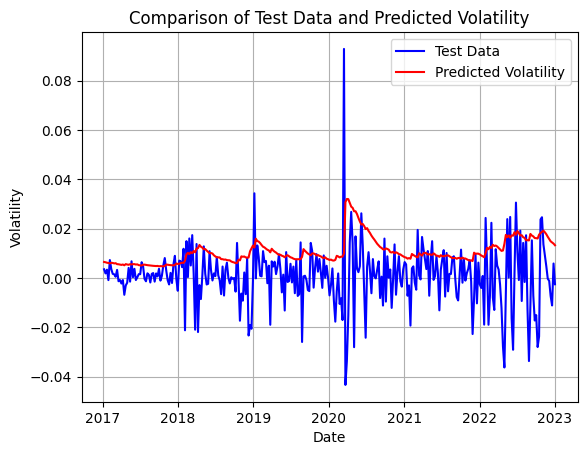

In [19]:
# Plot the test data and predicted volatility
plt.plot(test2_data.index, test2_data, color='blue', label='Test Data')
plt.plot(test2_data.index, predicted_values_garch, color='red', label='Predicted Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Comparison of Test Data and Predicted Volatility')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
evaluation(test2_data, predicted_values_garch)

Performance Metrics:
Mean Squared Error (MSE): 0.00027742744979651743
Root Mean Squared Error (RMSE): 0.01665615351143587
Mean Absolute Error (MAE): 0.011818496635216162
R-squared (R^2) Score: -0.8763402377210443


ARIMA model performance is better than GARCH model. The following hybrid models will use ARIMA model as the econometric model.

### Build_ANN_model_LSTM

In [21]:
#Hyperparemeter tuning: grid search for hyperparameter tuning.

C:\Users\10718\AppData\Local\Temp\ipykernel_18056\808144079.py:34: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regressor = KerasRegressor(build_fn=create_lstm_model)


Epoch 1/10
28/28 [==============================] - 6s 64ms/step - loss: 0.0112
Epoch 2/10
28/28 [==============================] - 2s 59ms/step - loss: 0.0059
Epoch 3/10
28/28 [==============================] - 2s 59ms/step - loss: 0.0051
Epoch 4/10
28/28 [==============================] - 2s 61ms/step - loss: 0.0047
Epoch 5/10
28/28 [==============================] - 2s 59ms/step - loss: 0.0042
Epoch 6/10
28/28 [==============================] - 2s 59ms/step - loss: 0.0039
Epoch 7/10
28/28 [==============================] - 2s 58ms/step - loss: 0.0036
Epoch 8/10
28/28 [==============================] - 2s 59ms/step - loss: 0.0034
Epoch 9/10
28/28 [==============================] - 2s 62ms/step - loss: 0.0031
Epoch 10/10
14/14 [==============================] - 1s 28ms/step - loss: 0.0012
Epoch 1/10
28/28 [==============================] - 5s 66ms/step - loss: 0.0099
Epoch 2/10
28/28 [==============================] - 2s 69ms/step - loss: 0.0055
Epoch 3/10
28/28 [=====================

28/28 [==============================] - 7s 246ms/step - loss: 0.0024
Epoch 6/10
28/28 [==============================] - 7s 244ms/step - loss: 0.0022
Epoch 7/10
28/28 [==============================] - 7s 240ms/step - loss: 0.0021
Epoch 8/10
28/28 [==============================] - 7s 232ms/step - loss: 0.0022
Epoch 9/10
28/28 [==============================] - 6s 212ms/step - loss: 0.0021
Epoch 10/10
14/14 [==============================] - 2s 82ms/step - loss: 9.5266e-04
Epoch 1/10
28/28 [==============================] - 9s 220ms/step - loss: 0.0237
Epoch 2/10
28/28 [==============================] - 6s 201ms/step - loss: 0.0040
Epoch 3/10
28/28 [==============================] - 6s 201ms/step - loss: 0.0033
Epoch 4/10
28/28 [==============================] - 6s 197ms/step - loss: 0.0029
Epoch 5/10
28/28 [==============================] - 5s 193ms/step - loss: 0.0030
Epoch 6/10
28/28 [==============================] - 5s 191ms/step - loss: 0.0027
Epoch 7/10
28/28 [=================

28/28 [==============================] - 2s 67ms/step - loss: 0.0034
Epoch 9/20
28/28 [==============================] - 2s 70ms/step - loss: 0.0031
Epoch 10/20
28/28 [==============================] - 2s 69ms/step - loss: 0.0031
Epoch 11/20
28/28 [==============================] - 2s 68ms/step - loss: 0.0029
Epoch 12/20
28/28 [==============================] - 2s 70ms/step - loss: 0.0030
Epoch 13/20
28/28 [==============================] - 2s 66ms/step - loss: 0.0028
Epoch 14/20
28/28 [==============================] - 2s 69ms/step - loss: 0.0028
Epoch 15/20
28/28 [==============================] - 2s 68ms/step - loss: 0.0028
Epoch 16/20
28/28 [==============================] - 2s 70ms/step - loss: 0.0025
Epoch 17/20
28/28 [==============================] - 2s 70ms/step - loss: 0.0025
Epoch 18/20
28/28 [==============================] - 2s 68ms/step - loss: 0.0024
Epoch 19/20
28/28 [==============================] - 2s 68ms/step - loss: 0.0024
Epoch 20/20
14/14 [======================

28/28 [==============================] - 6s 224ms/step - loss: 0.0019
Epoch 5/20
28/28 [==============================] - 6s 227ms/step - loss: 0.0018
Epoch 6/20
28/28 [==============================] - 6s 227ms/step - loss: 0.0016
Epoch 7/20
28/28 [==============================] - 6s 225ms/step - loss: 0.0015
Epoch 8/20
28/28 [==============================] - 7s 233ms/step - loss: 0.0015
Epoch 9/20
28/28 [==============================] - 7s 268ms/step - loss: 0.0014
Epoch 10/20
28/28 [==============================] - 8s 275ms/step - loss: 0.0014
Epoch 11/20
28/28 [==============================] - 7s 253ms/step - loss: 0.0013
Epoch 12/20
28/28 [==============================] - 7s 261ms/step - loss: 0.0013
Epoch 13/20
28/28 [==============================] - 8s 270ms/step - loss: 0.0013
Epoch 14/20
28/28 [==============================] - 8s 278ms/step - loss: 0.0012
Epoch 15/20
28/28 [==============================] - 8s 287ms/step - loss: 0.0012
Epoch 16/20
28/28 [==============

14/14 [==============================] - 2s 70ms/step - loss: 8.4668e-04
Epoch 1/20
28/28 [==============================] - 8s 143ms/step - loss: 0.0154
Epoch 2/20
28/28 [==============================] - 4s 140ms/step - loss: 0.0043
Epoch 3/20
28/28 [==============================] - 4s 144ms/step - loss: 0.0042
Epoch 4/20
28/28 [==============================] - 4s 144ms/step - loss: 0.0025
Epoch 5/20
28/28 [==============================] - 4s 146ms/step - loss: 0.0024
Epoch 6/20
28/28 [==============================] - 4s 148ms/step - loss: 0.0021
Epoch 7/20
28/28 [==============================] - 4s 157ms/step - loss: 0.0020
Epoch 8/20
28/28 [==============================] - 4s 155ms/step - loss: 0.0022
Epoch 9/20
28/28 [==============================] - 5s 164ms/step - loss: 0.0021
Epoch 10/20
28/28 [==============================] - 5s 165ms/step - loss: 0.0025
Epoch 11/20
28/28 [==============================] - 5s 171ms/step - loss: 0.0026
Epoch 12/20
28/28 [===============

28/28 [==============================] - 3s 103ms/step - loss: 0.0086
Epoch 18/20
28/28 [==============================] - 3s 99ms/step - loss: 0.0107
Epoch 19/20
28/28 [==============================] - 3s 99ms/step - loss: 0.0106
Epoch 20/20
14/14 [==============================] - 2s 29ms/step - loss: 0.0224
Epoch 1/20
28/28 [==============================] - 12s 255ms/step - loss: 5.3448
Epoch 2/20
28/28 [==============================] - 7s 260ms/step - loss: 0.0170
Epoch 3/20
28/28 [==============================] - 7s 259ms/step - loss: 0.0162
Epoch 4/20
28/28 [==============================] - 7s 258ms/step - loss: 0.0190
Epoch 5/20
28/28 [==============================] - 7s 263ms/step - loss: 0.0166
Epoch 6/20
28/28 [==============================] - 7s 265ms/step - loss: 0.0157
Epoch 7/20
28/28 [==============================] - 8s 273ms/step - loss: 0.0142
Epoch 8/20
28/28 [==============================] - 7s 267ms/step - loss: 0.0121
Epoch 9/20
28/28 [====================

14/14 [==============================] - 12s 558ms/step - loss: 0.0125
Epoch 2/10
14/14 [==============================] - 8s 579ms/step - loss: 0.0057
Epoch 3/10
14/14 [==============================] - 8s 579ms/step - loss: 0.0053
Epoch 4/10
14/14 [==============================] - 8s 580ms/step - loss: 0.0049
Epoch 5/10
14/14 [==============================] - 8s 559ms/step - loss: 0.0044
Epoch 6/10
14/14 [==============================] - 8s 564ms/step - loss: 0.0044
Epoch 7/10
14/14 [==============================] - 8s 551ms/step - loss: 0.0040
Epoch 8/10
14/14 [==============================] - 7s 538ms/step - loss: 0.0038
Epoch 9/10
14/14 [==============================] - 7s 529ms/step - loss: 0.0034
Epoch 10/10
7/7 [==============================] - 2s 128ms/step - loss: 0.0014
Epoch 1/10
14/14 [==============================] - 10s 440ms/step - loss: 0.0103
Epoch 2/10
14/14 [==============================] - 6s 452ms/step - loss: 0.0057
Epoch 3/10
14/14 [====================

14/14 [==============================] - 2s 156ms/step - loss: 0.0166
Epoch 5/10
14/14 [==============================] - 2s 177ms/step - loss: 0.0127
Epoch 6/10
14/14 [==============================] - 2s 176ms/step - loss: 0.0133
Epoch 7/10
14/14 [==============================] - 2s 171ms/step - loss: 0.0120
Epoch 8/10
14/14 [==============================] - 2s 177ms/step - loss: 0.0119
Epoch 9/10
14/14 [==============================] - 3s 178ms/step - loss: 0.0112
Epoch 10/10
7/7 [==============================] - 2s 44ms/step - loss: 0.0091
Epoch 1/10
14/14 [==============================] - 7s 180ms/step - loss: 2.9680
Epoch 2/10
14/14 [==============================] - 3s 201ms/step - loss: 0.5691
Epoch 3/10
14/14 [==============================] - 3s 211ms/step - loss: 0.0550
Epoch 4/10
14/14 [==============================] - 3s 215ms/step - loss: 0.0148
Epoch 5/10
14/14 [==============================] - 3s 212ms/step - loss: 0.0102
Epoch 6/10
14/14 [=======================

14/14 [==============================] - 3s 236ms/step - loss: 0.0026
Epoch 20/20
7/7 [==============================] - 1s 41ms/step - loss: 0.0016
Epoch 1/20
14/14 [==============================] - 8s 202ms/step - loss: 0.0073
Epoch 2/20
14/14 [==============================] - 3s 226ms/step - loss: 0.0032
Epoch 3/20
14/14 [==============================] - 3s 213ms/step - loss: 0.0027
Epoch 4/20
14/14 [==============================] - 3s 208ms/step - loss: 0.0025
Epoch 5/20
14/14 [==============================] - 3s 214ms/step - loss: 0.0023
Epoch 6/20
14/14 [==============================] - 3s 219ms/step - loss: 0.0023
Epoch 7/20
14/14 [==============================] - 3s 230ms/step - loss: 0.0022
Epoch 8/20
14/14 [==============================] - 3s 225ms/step - loss: 0.0021
Epoch 9/20
14/14 [==============================] - 3s 217ms/step - loss: 0.0021
Epoch 10/20
14/14 [==============================] - 3s 216ms/step - loss: 0.0020
Epoch 11/20
14/14 [=====================

14/14 [==============================] - 2s 140ms/step - loss: 0.0020
Epoch 16/20
14/14 [==============================] - 2s 134ms/step - loss: 0.0020
Epoch 17/20
14/14 [==============================] - 2s 142ms/step - loss: 0.0020
Epoch 18/20
14/14 [==============================] - 2s 147ms/step - loss: 0.0021
Epoch 19/20
14/14 [==============================] - 2s 144ms/step - loss: 0.0023
Epoch 20/20
7/7 [==============================] - 1s 40ms/step - loss: 8.8320e-04
Epoch 1/20
14/14 [==============================] - 6s 124ms/step - loss: 0.0116
Epoch 2/20
14/14 [==============================] - 2s 122ms/step - loss: 0.0047
Epoch 3/20
14/14 [==============================] - 2s 124ms/step - loss: 0.0035
Epoch 4/20
14/14 [==============================] - 2s 128ms/step - loss: 0.0027
Epoch 5/20
14/14 [==============================] - 2s 127ms/step - loss: 0.0027
Epoch 6/20
14/14 [==============================] - 2s 130ms/step - loss: 0.0025
Epoch 7/20
14/14 [===============

14/14 [==============================] - 5s 325ms/step - loss: 0.0012
Epoch 12/20
14/14 [==============================] - 5s 337ms/step - loss: 0.0012
Epoch 13/20
14/14 [==============================] - 5s 328ms/step - loss: 0.0011
Epoch 14/20
14/14 [==============================] - 4s 324ms/step - loss: 0.0011
Epoch 15/20
14/14 [==============================] - 5s 331ms/step - loss: 0.0011
Epoch 16/20
14/14 [==============================] - 5s 328ms/step - loss: 0.0010
Epoch 17/20
14/14 [==============================] - 5s 323ms/step - loss: 0.0011
Epoch 18/20
14/14 [==============================] - 5s 328ms/step - loss: 0.0010
Epoch 19/20
14/14 [==============================] - 4s 325ms/step - loss: 0.0011
Epoch 20/20
7/7 [==============================] - 2s 103ms/step - loss: 0.0030
Epoch 1/20
14/14 [==============================] - 6s 146ms/step - loss: 2.1783
Epoch 2/20
14/14 [==============================] - 2s 140ms/step - loss: 0.0185
Epoch 3/20
14/14 [==============

14/14 [==============================] - 5s 347ms/step - loss: 0.0168
Epoch 8/20
14/14 [==============================] - 5s 341ms/step - loss: 0.0150
Epoch 9/20
14/14 [==============================] - 5s 347ms/step - loss: 0.0149
Epoch 10/20
14/14 [==============================] - 5s 344ms/step - loss: 0.0146
Epoch 11/20
14/14 [==============================] - 5s 381ms/step - loss: 0.0143
Epoch 12/20
14/14 [==============================] - 5s 375ms/step - loss: 0.0130
Epoch 13/20
14/14 [==============================] - 5s 392ms/step - loss: 0.0122
Epoch 14/20
14/14 [==============================] - 6s 437ms/step - loss: 0.0126
Epoch 15/20
14/14 [==============================] - 6s 424ms/step - loss: 0.0117
Epoch 16/20
14/14 [==============================] - 6s 465ms/step - loss: 0.0078
Epoch 17/20
14/14 [==============================] - 7s 476ms/step - loss: 0.0060
Epoch 18/20
14/14 [==============================] - 7s 502ms/step - loss: 0.0066
Epoch 19/20
14/14 [===========

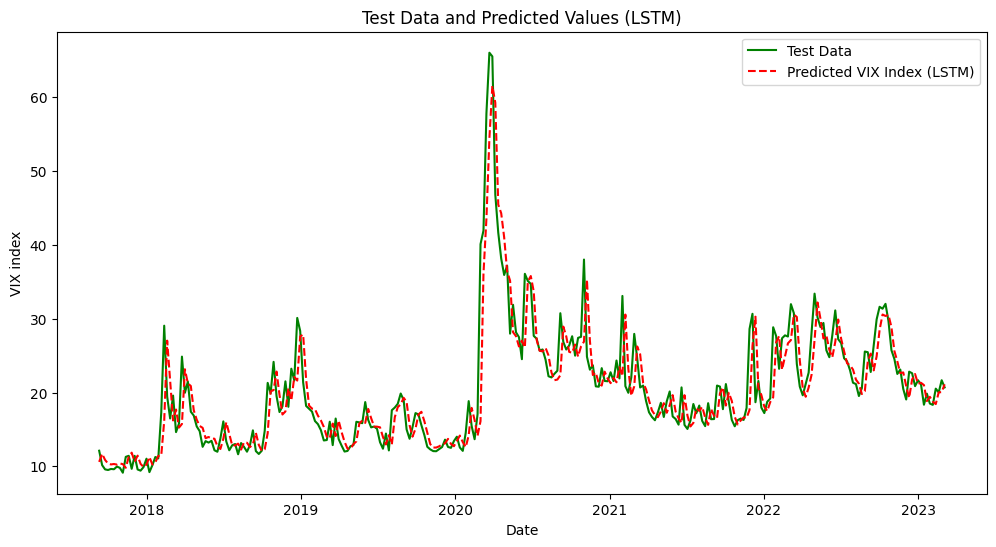

In [22]:
# Normalize the data
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(train_data.values.reshape(-1, 1))
test_data_normalized = scaler.transform(test_data.values.reshape(-1, 1))

# Prepare the training data
lookback = 60  # Number of previous time steps to consider

def create_sequences(data, lookback):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i - lookback:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data_normalized, lookback)
X_test, y_test = create_sequences(test_data_normalized, lookback)

# Reshape the input data for LSTM (batch_size, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Define the LSTM model
def create_lstm_model(units=50, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=units))
    model.add(Dense(units=1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Wrap the Keras model as a scikit-learn estimator
regressor = KerasRegressor(build_fn=create_lstm_model)

# Perform hyperparameter tuning using grid search
param_grid = {'units': [50, 100], 'batch_size': [32, 64], 'epochs': [10, 20], 'learning_rate': [0.001, 0.01, 0.1]}
model = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=3)
model.fit(X_train, y_train)

# Get the best hyperparameters
best_units = model.best_params_['units']
best_batch_size = model.best_params_['batch_size']
best_epochs = model.best_params_['epochs']
best_learning_rate = model.best_params_['learning_rate']

print(f"Best Hyperparameters: units={best_units}, batch_size={best_batch_size}, epochs={best_epochs}, learning_rate={best_learning_rate}")

# Train the LSTM model with the best hyperparameters
final_model = create_lstm_model(units=best_units, learning_rate=best_learning_rate)
final_model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size)

# Make predictions on the test data
predicted_values_lstm = final_model.predict(X_test)
predicted_values_lstm = scaler.inverse_transform(predicted_values_lstm)

# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(test_dates[lookback:], test_data[lookback:], color='green', label='Test Data')
plt.plot(test_dates[lookback:], predicted_values_lstm, color='red', linestyle='dashed', label='Predicted VIX Index (LSTM)')
plt.title('Test Data and Predicted Values (LSTM)')
plt.xlabel('Date')
plt.ylabel('VIX index')
plt.legend()
plt.show()


In [23]:
#Original version
# Normalize the data
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(train_data.values.reshape(-1, 1))

# Prepare the training data
lookback = 60  # Number of previous time steps to consider
X_train = []
y_train = []

for i in range(lookback, len(train_data_normalized)):
    X_train.append(train_data_normalized[i - lookback:i, 0])
    y_train.append(train_data_normalized[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the input data for LSTM (batch_size, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(units=1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
model_lstm.fit(X_train, y_train, epochs=10, batch_size=32)

# Prepare the test data
test_data_normalized = scaler.transform(test_data.values.reshape(-1, 1))

X_test = []
y_test = []

for i in range(lookback, len(test_data_normalized)):
    X_test.append(test_data_normalized[i - lookback:i, 0])
    y_test.append(test_data_normalized[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape the input data for LSTM (batch_size, timesteps, features)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Make predictions on the test data
predicted_values_lstm = model_lstm.predict(X_test)
predicted_values_lstm = scaler.inverse_transform(predicted_values_lstm)

Epoch 1/10
42/42 [==============================] - 7s 71ms/step - loss: 0.0071
Epoch 2/10
42/42 [==============================] - 3s 72ms/step - loss: 0.0043
Epoch 3/10
42/42 [==============================] - 3s 72ms/step - loss: 0.0036
Epoch 4/10
42/42 [==============================] - 3s 75ms/step - loss: 0.0031
Epoch 5/10
42/42 [==============================] - 3s 75ms/step - loss: 0.0028
Epoch 6/10
42/42 [==============================] - 3s 77ms/step - loss: 0.0026
Epoch 7/10
42/42 [==============================] - 3s 78ms/step - loss: 0.0025
Epoch 8/10
42/42 [==============================] - 3s 79ms/step - loss: 0.0023
Epoch 9/10
42/42 [==============================] - 3s 82ms/step - loss: 0.0022
Epoch 10/10
9/9 [==============================] - 1s 23ms/step


In [24]:
evaluation(test_data[lookback:], predicted_values_lstm)

Performance Metrics:
Mean Squared Error (MSE): 21.4861060334193
Root Mean Squared Error (RMSE): 4.635310780672564
Mean Absolute Error (MAE): 3.013865394991034
R-squared (R^2) Score: 0.6793184073675719


In [25]:
#Best Hyperparameters: units=50, batch_size=64, epochs=20, learning_rate=0.01

In [26]:
#Optimised version
# Normalize the data
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(train_data.values.reshape(-1, 1))

# Prepare the training data
lookback = 60  # Number of previous time steps to consider
X_train = []
y_train = []

for i in range(lookback, len(train_data_normalized)):
    X_train.append(train_data_normalized[i - lookback:i, 0])
    y_train.append(train_data_normalized[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the input data for LSTM (batch_size, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(units=1))
optimizer = Adam(learning_rate=0.01)
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
model_lstm.fit(X_train, y_train, epochs=20, batch_size=64)

# Prepare the test data
test_data_normalized = scaler.transform(test_data.values.reshape(-1, 1))

X_test = []
y_test = []

for i in range(lookback, len(test_data_normalized)):
    X_test.append(test_data_normalized[i - lookback:i, 0])
    y_test.append(test_data_normalized[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape the input data for LSTM (batch_size, timesteps, features)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Make predictions on the test data
predicted_values_lstm = model_lstm.predict(X_test)
predicted_values_lstm = scaler.inverse_transform(predicted_values_lstm)

Epoch 1/20
21/21 [==============================] - 8s 164ms/step - loss: 0.0092
Epoch 2/20
21/21 [==============================] - 4s 178ms/step - loss: 0.0049
Epoch 3/20
21/21 [==============================] - 4s 190ms/step - loss: 0.0042
Epoch 4/20
21/21 [==============================] - 4s 203ms/step - loss: 0.0038
Epoch 5/20
21/21 [==============================] - 4s 212ms/step - loss: 0.0036
Epoch 6/20
21/21 [==============================] - 5s 222ms/step - loss: 0.0033
Epoch 7/20
21/21 [==============================] - 5s 249ms/step - loss: 0.0031
Epoch 8/20
21/21 [==============================] - 5s 262ms/step - loss: 0.0028
Epoch 9/20
21/21 [==============================] - 6s 282ms/step - loss: 0.0027
Epoch 10/20
21/21 [==============================] - 8s 360ms/step - loss: 0.0025
Epoch 11/20
21/21 [==============================] - 7s 342ms/step - loss: 0.0024
Epoch 12/20
21/21 [==============================] - 7s 322ms/step - loss: 0.0023
Epoch 13/20
21/21 [======

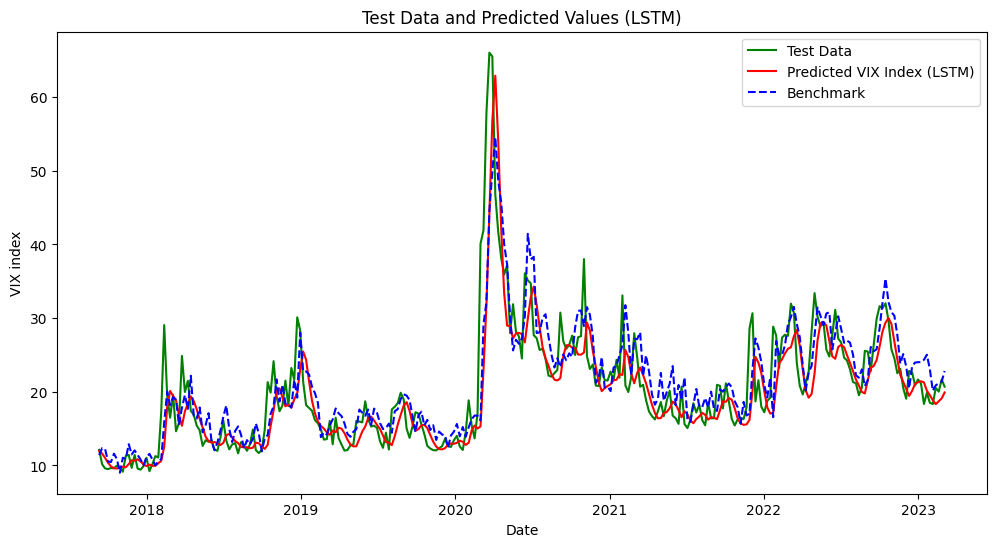

In [27]:
# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(test_dates[lookback:], test_data[lookback:], color='green', label='Test Data')
plt.plot(test_dates[lookback:], predicted_values_lstm, color='red', linestyle='-', label='Predicted VIX Index (LSTM)')
plt.plot(test_dates[lookback:], predicted_values_mlp, color='blue', linestyle='--', label='Benchmark')
plt.title('Test Data and Predicted Values (LSTM)')
plt.xlabel('Date')
plt.ylabel('VIX index')
plt.legend()
plt.show()

In [28]:
evaluation(test_data[lookback:], predicted_values_lstm)

Performance Metrics:
Mean Squared Error (MSE): 20.74800495753819
Root Mean Squared Error (RMSE): 4.554997799948776
Mean Absolute Error (MAE): 2.7609869775539493
R-squared (R^2) Score: 0.6903346160825949


In [29]:
evaluation(test_data[lookback:], predicted_values_mlp)

Performance Metrics:
Mean Squared Error (MSE): 20.269836834253987
Root Mean Squared Error (RMSE): 4.502203553178597
Mean Absolute Error (MAE): 3.044383063897854
R-squared (R^2) Score: 0.6974713078164221


### Build_ANN_model_GRU

In [30]:
#Original version
# Normalize the data
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(train_data.values.reshape(-1, 1))

# Prepare the training data
lookback = 60  # Number of previous time steps to consider
X_train = []
y_train = []

for i in range(lookback, len(train_data_normalized)):
    X_train.append(train_data_normalized[i - lookback:i, 0])
    y_train.append(train_data_normalized[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the input data for GRU (batch_size, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the GRU model
model_gru = Sequential()
model_gru.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_gru.add(GRU(units=50))
model_gru.add(Dense(units=1))
model_gru.compile(optimizer='adam', loss='mean_squared_error')

# Train the GRU model
model_gru.fit(X_train, y_train, epochs=10, batch_size=32)

# Prepare the test data
test_data_normalized = scaler.transform(test_data.values.reshape(-1, 1))

X_test = []
y_test = []

for i in range(lookback, len(test_data_normalized)):
    X_test.append(test_data_normalized[i - lookback:i, 0])
    y_test.append(test_data_normalized[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape the input data for GRU (batch_size, timesteps, features)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Make predictions on the test data
predicted_values_gru = model_gru.predict(X_test)
predicted_values_gru = scaler.inverse_transform(predicted_values_gru)


Epoch 1/10
42/42 [==============================] - 10s 95ms/step - loss: 0.0050
Epoch 2/10
42/42 [==============================] - 4s 99ms/step - loss: 0.0026
Epoch 3/10
42/42 [==============================] - 4s 94ms/step - loss: 0.0022
Epoch 4/10
42/42 [==============================] - 4s 90ms/step - loss: 0.0021
Epoch 5/10
42/42 [==============================] - 4s 86ms/step - loss: 0.0020
Epoch 6/10
42/42 [==============================] - 4s 86ms/step - loss: 0.0019
Epoch 7/10
42/42 [==============================] - 3s 78ms/step - loss: 0.0017
Epoch 8/10
42/42 [==============================] - 3s 79ms/step - loss: 0.0018
Epoch 9/10
42/42 [==============================] - 3s 75ms/step - loss: 0.0017
Epoch 10/10
9/9 [==============================] - 1s 21ms/step


In [31]:
evaluation(test_data[lookback:], predicted_values_gru)

Performance Metrics:
Mean Squared Error (MSE): 16.435054454122966
Root Mean Squared Error (RMSE): 4.054017076200219
Mean Absolute Error (MAE): 2.510186355537654
R-squared (R^2) Score: 0.7547056954316771


In [32]:
#Optimised version
# Normalize the data
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(train_data.values.reshape(-1, 1))

# Prepare the training data
lookback = 60  # Number of previous time steps to consider
X_train = []
y_train = []

for i in range(lookback, len(train_data_normalized)):
    X_train.append(train_data_normalized[i - lookback:i, 0])
    y_train.append(train_data_normalized[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the input data for GRU (batch_size, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the GRU model
model_gru = Sequential()
model_gru.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_gru.add(GRU(units=50))
model_gru.add(Dense(units=1))
optimizer = Adam(learning_rate=0.01)
model_gru.compile(optimizer='adam', loss='mean_squared_error')

# Train the GRU model
model_gru.fit(X_train, y_train, epochs=20, batch_size=64)

# Prepare the test data
test_data_normalized = scaler.transform(test_data.values.reshape(-1, 1))

X_test = []
y_test = []

for i in range(lookback, len(test_data_normalized)):
    X_test.append(test_data_normalized[i - lookback:i, 0])
    y_test.append(test_data_normalized[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape the input data for GRU (batch_size, timesteps, features)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Make predictions on the test data
predicted_values_gru = model_gru.predict(X_test)
predicted_values_gru = scaler.inverse_transform(predicted_values_gru)


Epoch 1/20
21/21 [==============================] - 6s 92ms/step - loss: 0.0086
Epoch 2/20
21/21 [==============================] - 2s 89ms/step - loss: 0.0031
Epoch 3/20
21/21 [==============================] - 2s 86ms/step - loss: 0.0026
Epoch 4/20
21/21 [==============================] - 2s 83ms/step - loss: 0.0024
Epoch 5/20
21/21 [==============================] - 2s 84ms/step - loss: 0.0022
Epoch 6/20
21/21 [==============================] - 2s 83ms/step - loss: 0.0021
Epoch 7/20
21/21 [==============================] - 2s 84ms/step - loss: 0.0019
Epoch 8/20
21/21 [==============================] - 2s 83ms/step - loss: 0.0019
Epoch 9/20
21/21 [==============================] - 2s 85ms/step - loss: 0.0019
Epoch 10/20
21/21 [==============================] - 2s 82ms/step - loss: 0.0018
Epoch 11/20
21/21 [==============================] - 2s 82ms/step - loss: 0.0017
Epoch 12/20
21/21 [==============================] - 2s 82ms/step - loss: 0.0017
Epoch 13/20
21/21 [==================

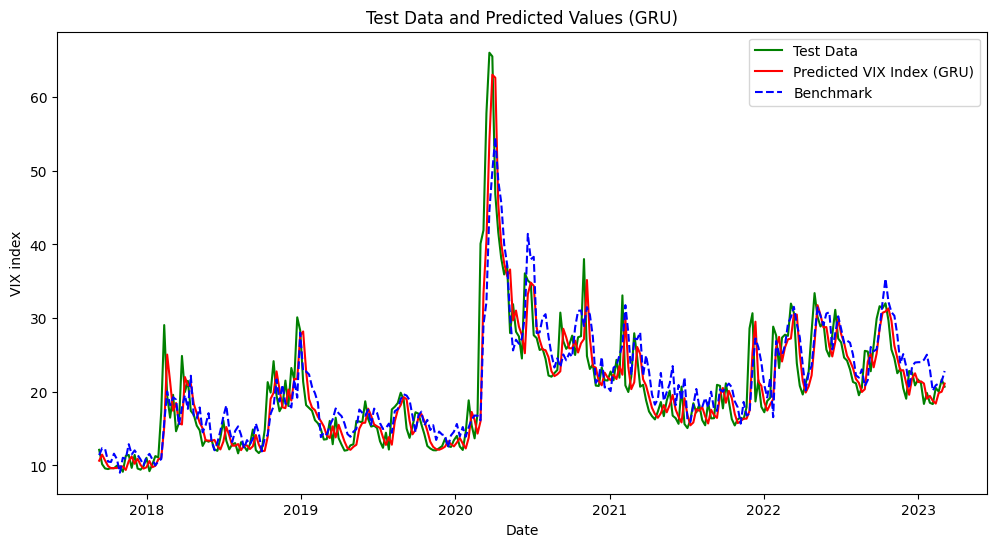

In [33]:
# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(test_dates[lookback:], test_data[lookback:], color='green', label='Test Data')
plt.plot(test_dates[lookback:], predicted_values_gru, color='red', linestyle='-', label='Predicted VIX Index (GRU)')
plt.plot(test_dates[lookback:], predicted_values_mlp, color='blue', linestyle='--', label='Benchmark')


plt.title('Test Data and Predicted Values (GRU)')
plt.xlabel('Date')
plt.ylabel('VIX index')
plt.legend()
plt.show()

In [34]:
evaluation(test_data[lookback:], predicted_values_gru)

Performance Metrics:
Mean Squared Error (MSE): 14.575954425738804
Root Mean Squared Error (RMSE): 3.8178468310998026
Mean Absolute Error (MAE): 2.4186812450661477
R-squared (R^2) Score: 0.7824528896900473


### Build_LSTM-ARIMA_model

In [35]:
model1_predictions_series = pd.Series(predicted_values_arima, index=test_dates)
# Normalize the data
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(model1_predictions_series.values.reshape(-1, 1))

# Prepare the training data
lookback = 60  # Number of previous time steps to consider
X_train = []
y_train = []

for i in range(lookback, len(train_data_normalized)):
    X_train.append(train_data_normalized[i - lookback:i, 0])
    y_train.append(train_data_normalized[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the input data for LSTM (batch_size, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(units=1))
optimizer = Adam(learning_rate=0.01)
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
model_lstm.fit(X_train, y_train, epochs=20, batch_size=64)

# Prepare the test data
test_data_normalized = scaler.transform(test_data.values.reshape(-1, 1))

X_test = []
y_test = []

for i in range(lookback, len(test_data_normalized)):
    X_test.append(test_data_normalized[i - lookback:i, 0])
    y_test.append(test_data_normalized[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape the input data for LSTM (batch_size, timesteps, features)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Make predictions on the test data
predicted_values_lstm_arima = scaler.inverse_transform(model_lstm.predict(X_test))

Epoch 1/20
5/5 [==============================] - 5s 129ms/step - loss: 0.0379
Epoch 2/20
5/5 [==============================] - 1s 116ms/step - loss: 0.0156
Epoch 3/20
5/5 [==============================] - 1s 109ms/step - loss: 0.0143
Epoch 4/20
5/5 [==============================] - 1s 114ms/step - loss: 0.0131
Epoch 5/20
5/5 [==============================] - 1s 111ms/step - loss: 0.0126
Epoch 6/20
5/5 [==============================] - 1s 115ms/step - loss: 0.0115
Epoch 7/20
5/5 [==============================] - 1s 129ms/step - loss: 0.0115
Epoch 8/20
5/5 [==============================] - 1s 124ms/step - loss: 0.0110
Epoch 9/20
5/5 [==============================] - 1s 112ms/step - loss: 0.0108
Epoch 10/20
5/5 [==============================] - 1s 119ms/step - loss: 0.0104
Epoch 11/20
5/5 [==============================] - 1s 117ms/step - loss: 0.0102
Epoch 12/20
5/5 [==============================] - 1s 117ms/step - loss: 0.0100
Epoch 13/20
5/5 [==============================] 

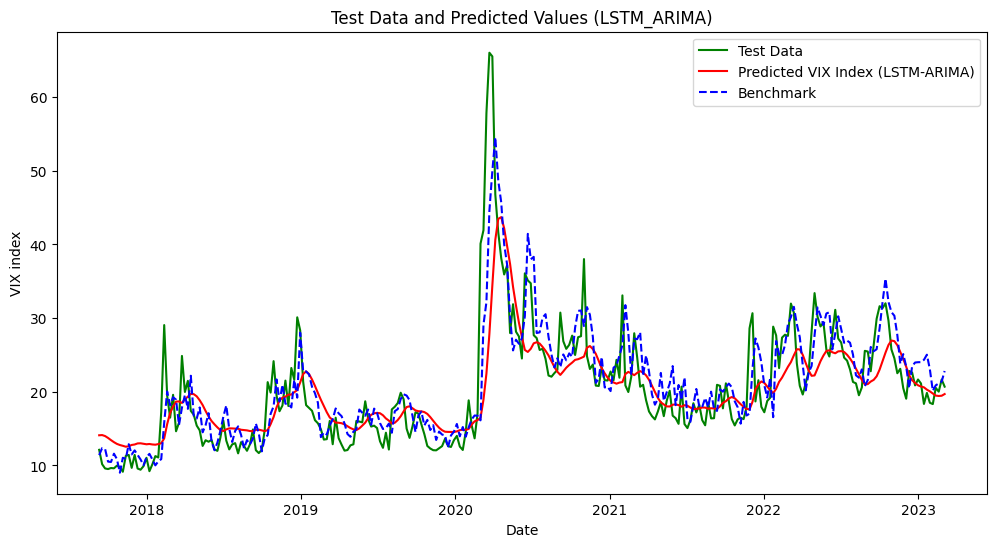

In [36]:
# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(test_dates[lookback:], test_data[lookback:], color='green', label='Test Data')
plt.plot(test_dates[lookback:], predicted_values_lstm_arima, color='red', linestyle='-', label='Predicted VIX Index (LSTM-ARIMA)')
plt.plot(test_dates[lookback:], predicted_values_mlp, color='blue', linestyle='--', label='Benchmark')


plt.title('Test Data and Predicted Values (LSTM_ARIMA)')
plt.xlabel('Date')
plt.ylabel('VIX index')
plt.legend()
plt.show()


In [37]:
evaluation(test_data[lookback:], predicted_values_lstm_arima)

Performance Metrics:
Mean Squared Error (MSE): 31.162481387921126
Root Mean Squared Error (RMSE): 5.582336552727821
Mean Absolute Error (MAE): 3.45934202546442
R-squared (R^2) Score: 0.5348978476456573


### Build_ARIMA-LSTM_model

In [38]:
# Train AutoARIMA model
history = [x[0] for x in predicted_values_lstm]
model = auto_arima(history, trace=True, error_action='ignore', suppress_warnings=True)
# Fit the model
model.fit(history)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=995.233, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1247.988, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1070.227, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1079.992, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1246.037, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1014.730, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=995.190, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1029.224, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1001.034, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1000.143, Time=0.11 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=997.129, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=998.899, Time=0.35 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=993.243, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1027.240, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : 

ARIMA(order=(2, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [39]:
#One_step ahead forecast
predicted_values_arima_lstm = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(3,1,3))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predicted_values_arima_lstm.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)


C:\Users\10718\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\10718\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\10718\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\10718\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\10718\anaconda3\lib\site-packages\statsmodels\base\model

C:\Users\10718\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\10718\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\10718\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


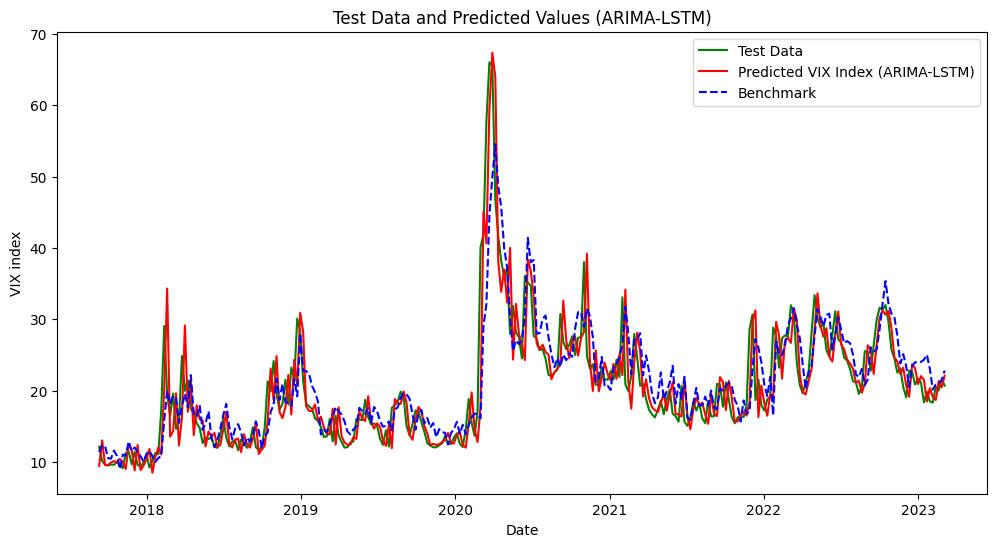

In [40]:
# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(test_dates[60:], test_data[60:], color='green', label='Test Data')
plt.plot(test_dates[60:], predicted_values_arima_lstm[60:], color='red', linestyle='-', label='Predicted VIX Index (ARIMA-LSTM)')
plt.plot(test_dates[60:], predicted_values_mlp, color='blue', linestyle='--', label='Benchmark')


plt.title('Test Data and Predicted Values (ARIMA-LSTM)')
plt.xlabel('Date')
plt.ylabel('VIX index')
plt.legend()
plt.show()

In [41]:
evaluation(test_data, predicted_values_arima_lstm)

Performance Metrics:
Mean Squared Error (MSE): 15.636213959708448
Root Mean Squared Error (RMSE): 3.9542652869665242
Mean Absolute Error (MAE): 2.6134271516483456
R-squared (R^2) Score: 0.7608310965867799


### Build_GRU-ARIMA_model

In [42]:
model1_predictions_series = pd.Series(predicted_values_arima, index=test_dates)
# Normalize the data
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(model1_predictions_series.values.reshape(-1, 1))

# Prepare the training data
lookback = 60  # Number of previous time steps to consider
X_train = []
y_train = []

for i in range(lookback, len(train_data_normalized)):
    X_train.append(train_data_normalized[i - lookback:i, 0])
    y_train.append(train_data_normalized[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the input data for GRU (batch_size, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the GRU model
model_gru = Sequential()
model_gru.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_gru.add(GRU(units=50))
model_gru.add(Dense(units=1))
optimizer = Adam(learning_rate=0.01)
model_gru.compile(optimizer='adam', loss='mean_squared_error')

# Train the GRU model
model_gru.fit(X_train, y_train, epochs=20, batch_size=64)

# Prepare the test data
test_data_normalized = scaler.transform(test_data.values.reshape(-1, 1))

X_test = []
y_test = []

for i in range(lookback, len(test_data_normalized)):
    X_test.append(test_data_normalized[i - lookback:i, 0])
    y_test.append(test_data_normalized[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape the input data for GRU (batch_size, timesteps, features)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Make predictions on the test data
predicted_values_gru_arima = scaler.inverse_transform(model_gru.predict(X_test))

Epoch 1/20
5/5 [==============================] - 5s 72ms/step - loss: 0.0303
Epoch 2/20
5/5 [==============================] - 0s 80ms/step - loss: 0.0136
Epoch 3/20
5/5 [==============================] - 0s 82ms/step - loss: 0.0113
Epoch 4/20
5/5 [==============================] - 0s 86ms/step - loss: 0.0085
Epoch 5/20
5/5 [==============================] - 0s 86ms/step - loss: 0.0087
Epoch 6/20
5/5 [==============================] - 0s 86ms/step - loss: 0.0073
Epoch 7/20
5/5 [==============================] - 0s 84ms/step - loss: 0.0070
Epoch 8/20
5/5 [==============================] - 0s 83ms/step - loss: 0.0065
Epoch 9/20
5/5 [==============================] - 0s 84ms/step - loss: 0.0064
Epoch 10/20
5/5 [==============================] - 0s 83ms/step - loss: 0.0062
Epoch 11/20
5/5 [==============================] - 0s 84ms/step - loss: 0.0059
Epoch 12/20
5/5 [==============================] - 0s 83ms/step - loss: 0.0058
Epoch 13/20
5/5 [==============================] - 0s 86ms/st

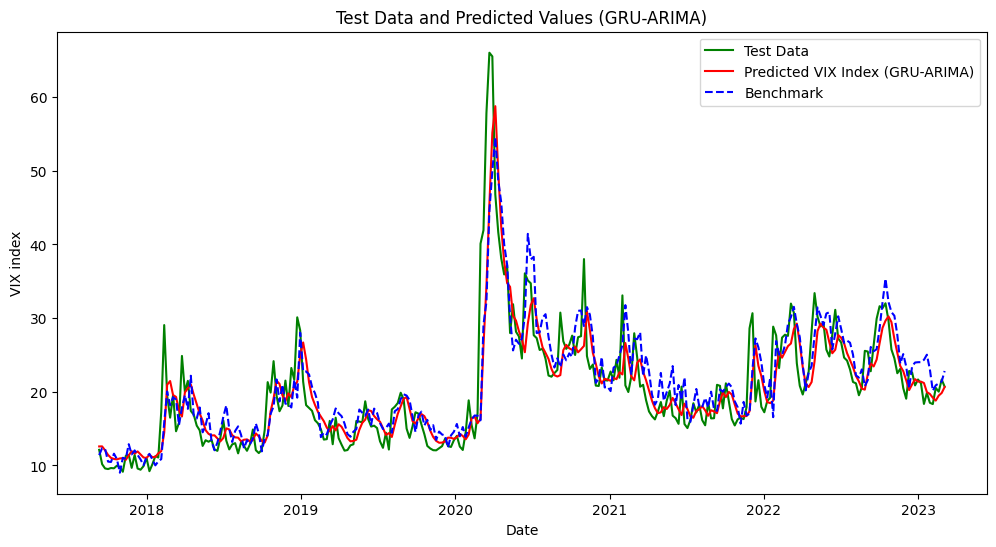

In [43]:
# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(test_dates[lookback:], test_data[lookback:], color='green', label='Test Data')
plt.plot(test_dates[lookback:], predicted_values_gru_arima, color='red', linestyle='-', label='Predicted VIX Index (GRU-ARIMA)')
plt.plot(test_dates[lookback:], predicted_values_mlp, color='blue', linestyle='--', label='Benchmark')

plt.title('Test Data and Predicted Values (GRU-ARIMA)')
plt.xlabel('Date')
plt.ylabel('VIX index')
plt.legend()
#plt.grid(True)
plt.show()

### Build_ARIMA-GRU_model

In [44]:
# Train AutoARIMA model
history = [x[0] for x in predicted_values_gru]
model = auto_arima(history, trace=True, error_action='ignore', suppress_warnings=True)
# Fit the model
model.fit(history)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1430.729, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1417.269, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1416.404, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1428.774, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1418.314, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1418.249, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1417.757, Time=0.29 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1414.438, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1416.347, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1416.281, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1415.300, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1415.789, Time=0.16 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.547 seconds


ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [45]:
#One_step ahead forecast
predicted_values_arima_gru = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(2,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predicted_values_arima_gru.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)


C:\Users\10718\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\10718\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


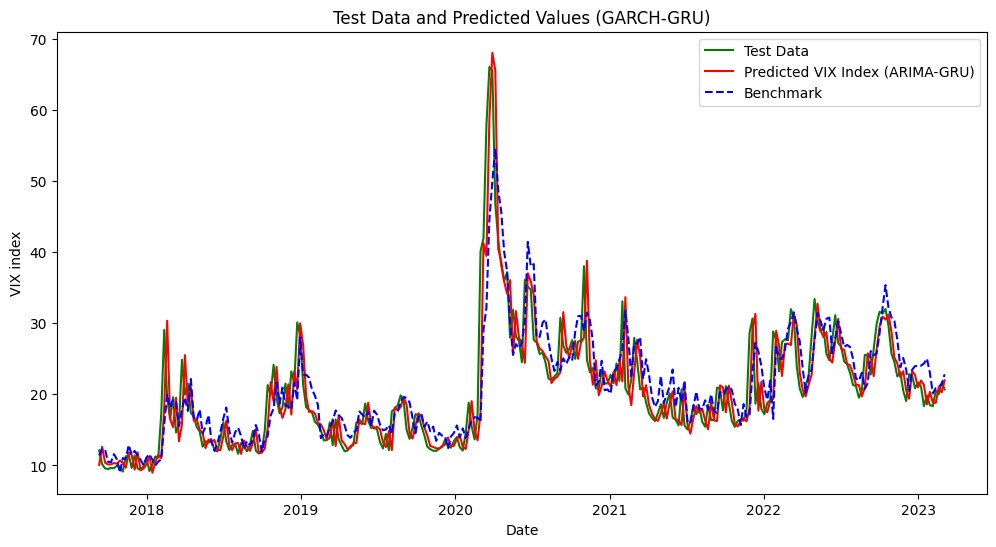

In [46]:
# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(test_dates[60:], test_data[60:], color='green', label='Test Data')
plt.plot(test_dates[60:], predicted_values_arima_gru[60:], color='red', linestyle='-', label='Predicted VIX Index (ARIMA-GRU)')
plt.plot(test_dates[lookback:], predicted_values_mlp, color='blue', linestyle='--', label='Benchmark')

plt.title('Test Data and Predicted Values (GARCH-GRU)')
plt.xlabel('Date')
plt.ylabel('VIX index')
plt.legend()
plt.show()

In [47]:
evaluation(test_data, predicted_values_arima_gru)

Performance Metrics:
Mean Squared Error (MSE): 13.773847578634095
Root Mean Squared Error (RMSE): 3.71131345734015
Mean Absolute Error (MAE): 2.3245480858302385
R-squared (R^2) Score: 0.7893175400610738


## Strategies

### Combine_models_prediction_results

In [48]:
y_lstm = pd.Series([x[0] for x in predicted_values_lstm], index = test_dates[60:])
y_lstm_arima = pd.Series([x[0] for x in predicted_values_lstm_arima], index = test_dates[60:])
y_arima_lstm = pd.Series(predicted_values_arima_lstm[60:],index =test_dates[60:])
y_gru = pd.Series([x[0] for x in predicted_values_gru], index = test_dates[60:])
y_gru_arima = pd.Series([x[0] for x in predicted_values_gru_arima], index = test_dates[60:])
y_arima_gru = pd.Series(predicted_values_arima_gru[60:],index =test_dates[60:])
y_benchmark = pd.Series([x[0] for x in predicted_values_mlp], index = test_dates[60:])
y_test = test_data[60:]

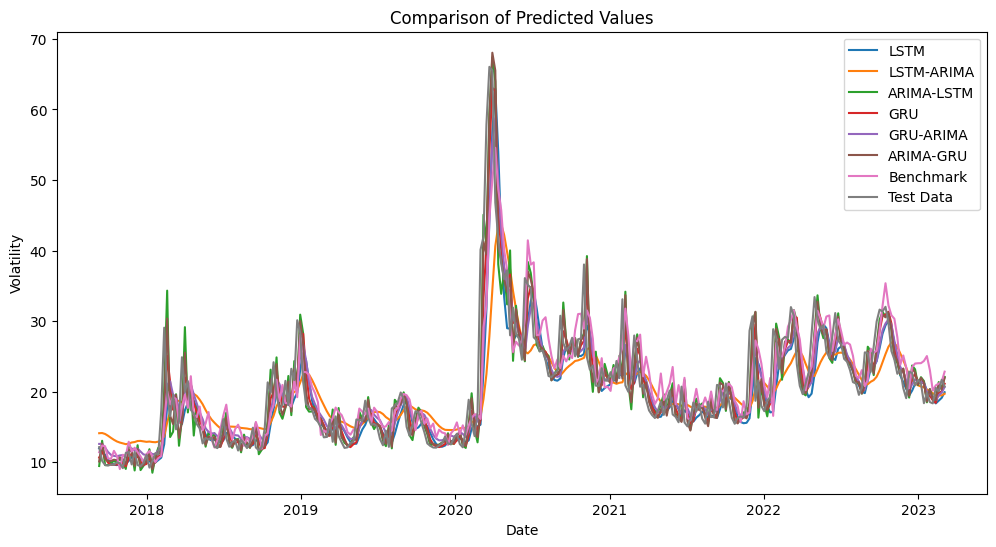

In [49]:
plt.figure(figsize=(12, 6))
# Plot the y-values
plt.plot(y_lstm, label='LSTM')
plt.plot(y_lstm_arima, label='LSTM-ARIMA')
plt.plot(y_arima_lstm, label='ARIMA-LSTM')
plt.plot(y_gru, label='GRU')
plt.plot(y_gru_arima, label='GRU-ARIMA')
plt.plot(y_arima_gru, label='ARIMA-GRU')
plt.plot(y_benchmark, label='Benchmark')
plt.plot(y_test, label='Test Data')

# Set the title and labels
plt.title('Comparison of Predicted Values')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()

# Display the plot
plt.show()

In [50]:
models = ["Benchmark",'LSTM', 'LSTM_ARIMA', 'ARIMA_LSTM', 'GRU', 'GRU_ARIMA', 'ARIMA_GRU',"Test_data"]
predictions = [y_benchmark, y_lstm, y_lstm_arima, y_arima_lstm, y_gru, y_gru_arima, y_arima_gru,y_test]

data_vol = {model: prediction for model, prediction in zip(models, predictions)}

# Create the DataFrame
df_vol = pd.DataFrame(data_vol)

In [51]:
df_vol

,Benchmark,LSTM,LSTM_ARIMA,ARIMA_LSTM,GRU,GRU_ARIMA,ARIMA_GRU,Test_data
Date,,,,,,,,
2017-09-10,11.401204,11.951177,14.095769,9.446845,10.643682,12.580231,10.089413,12.12
2017-09-17,12.354041,11.613625,14.124296,13.021974,11.468910,12.585368,12.630816,10.17
2017-09-24,12.240746,11.015320,13.989577,9.566174,10.668263,12.050905,10.401839,9.59
2017-10-01,10.520952,10.358240,13.734103,9.585839,9.916353,11.431963,10.143301,9.51
2017-10-08,10.469963,9.867318,13.435983,9.917953,9.617292,11.025826,10.168410,9.65
...,...,...,...,...,...,...,...,...
2023-02-05,20.139570,18.850819,19.771973,19.108496,18.776621,19.195961,18.861398,18.33
2023-02-12,20.877499,18.319174,19.483110,18.690680,18.400602,18.803606,18.802099,20.53
2023-02-19,21.136692,18.703766,19.432402,21.350659,19.844090,19.481758,21.005131,20.02


### Evaluation_method_1_index_metrics

In [52]:
#Evaluation method 1: index metrics (Prediction accuracy) Ref: Main1
#1 Testing accuracy ratio for modelling (bar plot/box plot)
#2 MSE, RMSE, MAE, etc...

In [53]:
# Calculate statistical measures for each model
metrics = ['MSE', 'RMSE', 'MAE', 'Correlation', 'Cosine Similarity']
results = []

for column in df_vol.columns[:-1]:  # Exclude the 'Test_data' column
    model_data = df_vol[column]
    # Calculate statistical measures
    mse = np.mean((model_data - df_vol['Test_data']) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(model_data - df_vol['Test_data']))
    correlation = np.corrcoef(model_data, df_vol['Test_data'])[0, 1]
    cosine_similarity = np.dot(model_data, df_vol['Test_data']) / (np.linalg.norm(model_data) * np.linalg.norm(df_vol['Test_data']))
    
    # Store the results
    results.append([mse, rmse, mae, correlation, cosine_similarity])

# Create a DataFrame to display the results
df_results = pd.DataFrame(results, columns=metrics, index=df_vol.columns[:-1])

# Sort the models based on the similarity metrics (choose the desired metric as per your preference)
df_results_sorted_vol = df_results.sort_values(by='MSE', ascending=True)

In [54]:
df_results_sorted_vol

,MSE,RMSE,MAE,Correlation,Cosine Similarity
GRU,14.575954,3.817847,2.418681,0.886939,0.984651
ARIMA_GRU,15.166417,3.894408,2.429574,0.885231,0.984054
ARIMA_LSTM,16.575354,4.071284,2.645625,0.875989,0.982649
GRU_ARIMA,17.552271,4.189543,2.697373,0.859726,0.981527
Benchmark,20.269837,4.502204,3.044383,0.841545,0.979346
LSTM,20.748005,4.554998,2.760987,0.838642,0.978710
LSTM_ARIMA,31.162481,5.582337,3.459342,0.739753,0.967208


In [55]:
df_vol

,Benchmark,LSTM,LSTM_ARIMA,ARIMA_LSTM,GRU,GRU_ARIMA,ARIMA_GRU,Test_data
Date,,,,,,,,
2017-09-10,11.401204,11.951177,14.095769,9.446845,10.643682,12.580231,10.089413,12.12
2017-09-17,12.354041,11.613625,14.124296,13.021974,11.468910,12.585368,12.630816,10.17
2017-09-24,12.240746,11.015320,13.989577,9.566174,10.668263,12.050905,10.401839,9.59
2017-10-01,10.520952,10.358240,13.734103,9.585839,9.916353,11.431963,10.143301,9.51
2017-10-08,10.469963,9.867318,13.435983,9.917953,9.617292,11.025826,10.168410,9.65
...,...,...,...,...,...,...,...,...
2023-02-05,20.139570,18.850819,19.771973,19.108496,18.776621,19.195961,18.861398,18.33
2023-02-12,20.877499,18.319174,19.483110,18.690680,18.400602,18.803606,18.802099,20.53
2023-02-19,21.136692,18.703766,19.432402,21.350659,19.844090,19.481758,21.005131,20.02


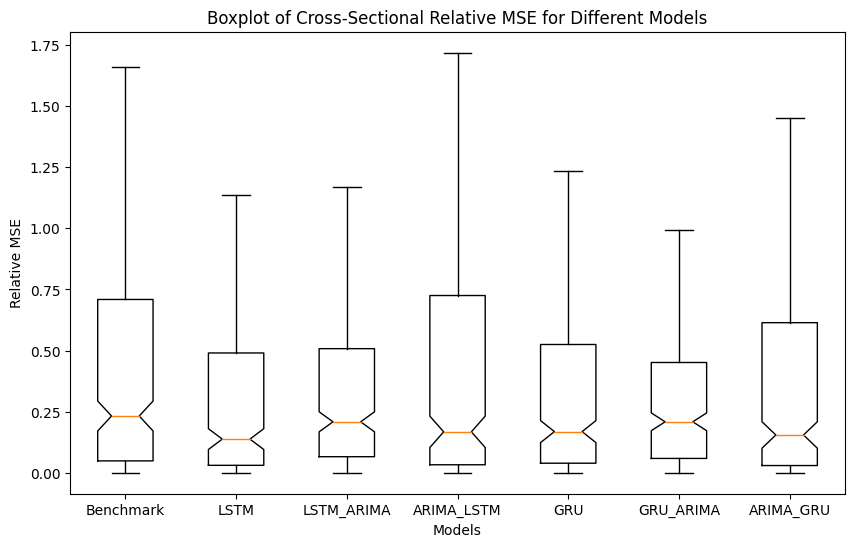

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Calculate relative MSE for each model
models = df_vol.columns[:-1]  # Extract the model names from df_vol
relative_mse_values = []

for model in models:
    mse_values = (df_vol['Test_data'] - df_vol[model]) ** 2
    relative_mse = mse_values / np.mean(mse_values)
    relative_mse_values.append(relative_mse)

# Create boxplots of relative MSE for different models
plt.figure(figsize=(10, 6))
plt.boxplot(relative_mse_values, vert=True, showfliers=False, notch=True, labels=models)
plt.xlabel('Models')
plt.ylabel('Relative MSE')
plt.title('Boxplot of Cross-Sectional Relative MSE for Different Models')
plt.show()


### Evaluation_method_2_trading_strategies

In [57]:
#Input s&p500 historical data and create benchmark
sp500 = pd.read_csv("SPY.csv")
sp500.index = pd.to_datetime(sp500["Date"])
sp500_return= sp500.loc[y_test.index[0]:y_test.index[-1]]["Adj Close"].pct_change()
sp500_value = []
value = 1
for i in sp500_return[1:]:
    value *= (1+i)
    sp500_value.append(value)
sp500_value.insert(0,1)

In [58]:
models = ["Benchmark",'LSTM', 'LSTM_ARIMA', 'ARIMA_LSTM', 'GRU', 'GRU_ARIMA', 'ARIMA_GRU']
predictions = [y_benchmark, y_lstm, y_lstm_arima, y_arima_lstm, y_gru, y_gru_arima, y_arima_gru]

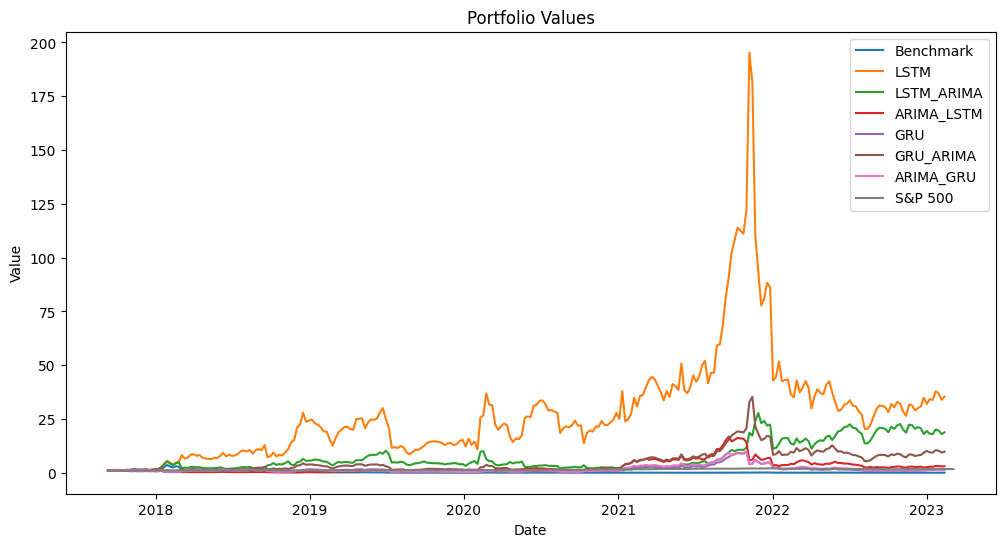

In [59]:
# Initialize portfolio values
portfolio_values = pd.DataFrame(index=y_test.index, columns=models)
y_test_return = y_test.pct_change()
# Calculate portfolio values for each model
for i, model in enumerate(models):
    signal_models = np.sign(predictions[i].diff())  # Calculate signal based on predicted values
    signal_test = np.sign(y_test.diff())
    signal = [-1 if signal_models[i] == signal_test[i] else 1 for i in range(len(signal_models))]
    portfolio_values[model] = (1 + signal * abs(y_test_return.shift(-3))).cumprod()  # Calculate portfolio values

portfolio_values["S&P500"] = sp500_value
# Plot portfolio values
plt.figure(figsize=(12, 6))
for model in models:
    plt.plot(portfolio_values.index, portfolio_values[model], label=model)
plt.plot(portfolio_values.index, sp500_value, label="S&P 500")
plt.title("Portfolio Values")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()

In [60]:
# Calculate daily returns for each model
daily_returns = portfolio_values.pct_change()

# Calculate Sharpe ratio
risk_free_rate = 0.0  # Set the risk-free rate
sharpe_ratio = (daily_returns.mean() - risk_free_rate) / daily_returns.std()

# Create table for daily returns
daily_returns_table = pd.DataFrame(daily_returns.mean(), columns=["Weekly Return"])
daily_returns_table["Std Dev"] = daily_returns.std()
daily_returns_table["Sharpe Ratio"] = sharpe_ratio
daily_returns_table = daily_returns_table.round(4)

# Sort the table by "Weekly Return" column in descending order
daily_returns_table = daily_returns_table.sort_values(by="Weekly Return", ascending=False)

# Display table for daily returns and Sharpe ratio
print("Weekly Returns and Sharpe Ratio:")
daily_returns_table

Weekly Returns and Sharpe Ratio:


,Weekly Return,Std Dev,Sharpe Ratio
LSTM,0.0266,0.1763,0.1507
LSTM_ARIMA,0.0251,0.1765,0.1423
GRU_ARIMA,0.0231,0.1768,0.1309
ARIMA_LSTM,0.0198,0.1772,0.1115
GRU,0.0168,0.1775,0.0946
ARIMA_GRU,0.0166,0.1775,0.0937
Benchmark,0.0040,0.1783,0.0227
S&P500,0.0023,0.0280,0.0808


### Evaluation_method_3_Option_pricing

In [61]:
#Black-Scholes model

In [62]:
def black_scholes(S, K, r, T, sigma, option_type):
    d1 = (math.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    
    if option_type == 'call':
        price = S * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        price = K * math.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Choose 'call' or 'put'.")
    
    return price

#### Call_option

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

# Time series data for S&P 500 stock prices
sp500_price = sp500.loc[y_test.index[0]:y_test.index[-1]]["Adj Close"]

# Volatility predictions for each model
models = ["Benchmark", 'LSTM', 'LSTM_ARIMA', 'ARIMA_LSTM', 'GRU', 'GRU_ARIMA', 'ARIMA_GRU',"Test data"]
predictions = [y_benchmark, y_lstm, y_lstm_arima, y_arima_lstm, y_gru, y_gru_arima, y_arima_gru,y_test]

# Parameters for option pricing
risk_free_rate = 0.05  # Risk-free interest rate (r)
time_to_maturity = 0.5  # Time to option expiration in years (T)

# Generate option prices for each model
option_prices = []
for model, volatility in zip(models, predictions):
    option_prices_model = []
    for stock_price, sigma in zip(sp500_price, volatility):
        strike_price = stock_price + 50  # Strike price is $50 higher than S&P 500 price
        option_price = black_scholes(stock_price, strike_price, risk_free_rate, time_to_maturity, 0.01*sigma, 'call')
        option_prices_model.append(option_price)
    option_prices.append(option_prices_model)

# Create a DataFrame from the option prices
data_option = list(map(list, zip(*option_prices)))
df_option = pd.DataFrame(data_option, columns=models)
df_option = df_option.set_index(y_test.index)

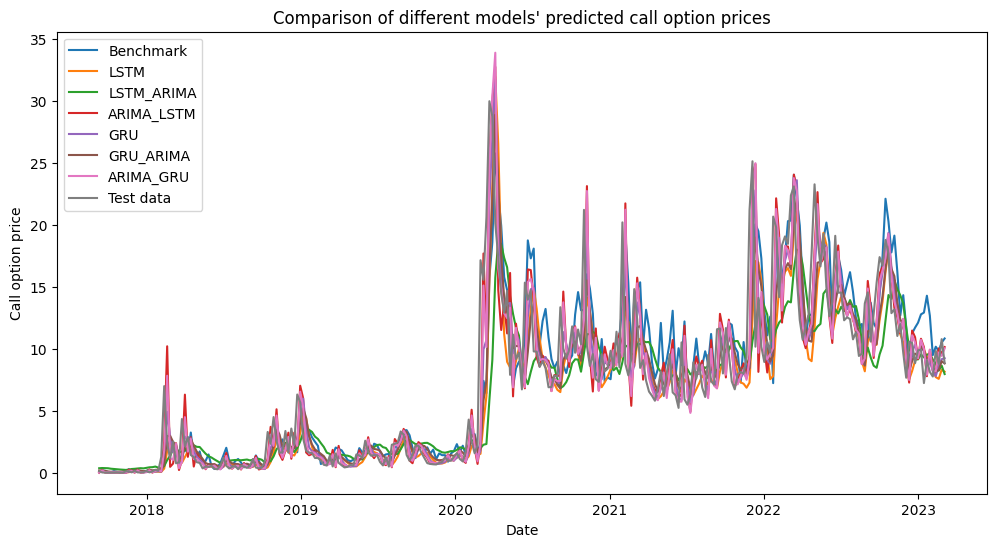

In [64]:
# Plotting the time series data for each model
plt.figure(figsize=(12, 6))
for column in df_option.columns:
    plt.plot(df_option.index, df_option[column], label=column)

# Set the title, x-axis label, and y-axis label
plt.title("Comparison of different models' predicted call option prices")
plt.xlabel('Date')
plt.ylabel('Call option price')

# Add a legend
plt.legend()

# Display the plot
plt.show()


In [65]:
import numpy as np

# Calculate statistical measures for each model
metrics = ['MSE', 'RMSE', 'MAE', 'Correlation', 'Cosine Similarity']
results = []

for column in df_option.columns[:-1]:  # Exclude the 'Test_data' column
    model_data = df_option[column]
    
    # Calculate statistical measures
    mse = np.mean((model_data - df_option['Test data']) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(model_data - df_option['Test data']))
    correlation = np.corrcoef(model_data, df_option['Test data'])[0, 1]
    cosine_similarity = np.dot(model_data, df_option['Test data']) / (np.linalg.norm(model_data) * np.linalg.norm(df_option['Test data']))
    
    # Store the results
    results.append([mse, rmse, mae, correlation, cosine_similarity])

# Create a DataFrame to display the results
df_results = pd.DataFrame(results, columns=metrics, index=df_option.columns[:-1])

# Sort the models based on the similarity metrics (choose the desired metric as per your preference)
df_results_sorted_option = df_results.sort_values(by='MSE', ascending=True)

In [66]:
df_results_sorted_option

,MSE,RMSE,MAE,Correlation,Cosine Similarity
GRU,8.572640,2.927907,1.704413,0.890319,0.951208
ARIMA_GRU,9.092905,3.015444,1.705061,0.887144,0.949061
ARIMA_LSTM,9.670061,3.109672,1.826259,0.880991,0.946475
GRU_ARIMA,9.734650,3.120040,1.856574,0.871268,0.944087
LSTM,11.443346,3.382802,1.934342,0.852844,0.934454
Benchmark,11.808695,3.436378,2.184989,0.860028,0.939141
LSTM_ARIMA,15.056816,3.880311,2.267215,0.795212,0.913621


#### Put_option

In [67]:
import pandas as pd
import matplotlib.pyplot as plt

# Time series data for S&P 500 stock prices
sp500_price = sp500.loc[y_test.index[0]:y_test.index[-1]]["Adj Close"]

# Volatility predictions for each model
models = ["Benchmark", 'LSTM', 'LSTM_ARIMA', 'ARIMA_LSTM', 'GRU', 'GRU_ARIMA', 'ARIMA_GRU',"Test data"]
predictions = [y_benchmark, y_lstm, y_lstm_arima, y_arima_lstm, y_gru, y_gru_arima, y_arima_gru,y_test]

# Parameters for option pricing
risk_free_rate = 0.05  # Risk-free interest rate (r)
time_to_maturity = 0.5  # Time to option expiration in years (T)

# Generate option prices for each model
option_prices = []
for model, volatility in zip(models, predictions):
    option_prices_model = []
    for stock_price, sigma in zip(sp500_price, volatility):
        strike_price = stock_price - 50  # Strike price is $50 higher than S&P 500 price
        option_price = black_scholes(stock_price, strike_price, risk_free_rate, time_to_maturity, 0.01*sigma, 'put')
        option_prices_model.append(option_price)
    option_prices.append(option_prices_model)

# Create a DataFrame from the option prices
data_option = list(map(list, zip(*option_prices)))
df_option = pd.DataFrame(data_option, columns=models)
df_option = df_option.set_index(y_test.index)

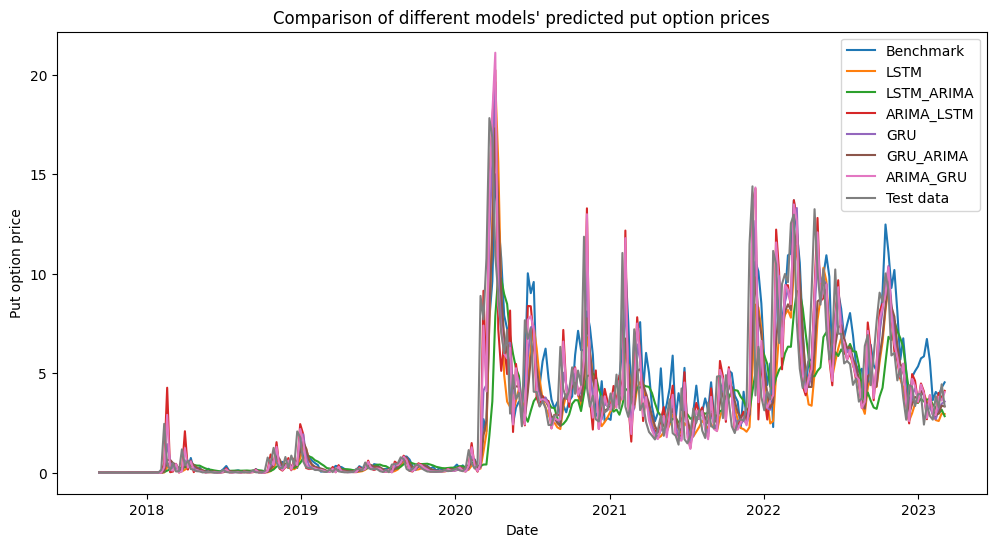

In [68]:
# Plotting the time series data for each model
plt.figure(figsize=(12, 6))
for column in df_option.columns:
    plt.plot(df_option.index, df_option[column], label=column)

# Set the title, x-axis label, and y-axis label
plt.title("Comparison of different models' predicted put option prices")
plt.xlabel('Date')
plt.ylabel('Put option price')

# Add a legend
plt.legend()

# Display the plot
plt.show()


In [69]:
import numpy as np

# Calculate statistical measures for each model
metrics = ['MSE', 'RMSE', 'MAE', 'Correlation', 'Cosine Similarity']
results = []

for column in df_option.columns[:-1]:  # Exclude the 'Test_data' column
    model_data = df_option[column]
    
    # Calculate statistical measures
    mse = np.mean((model_data - df_option['Test data']) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(model_data - df_option['Test data']))
    correlation = np.corrcoef(model_data, df_option['Test data'])[0, 1]
    cosine_similarity = np.dot(model_data, df_option['Test data']) / (np.linalg.norm(model_data) * np.linalg.norm(df_option['Test data']))
    
    # Store the results
    results.append([mse, rmse, mae, correlation, cosine_similarity])

# Create a DataFrame to display the results
df_results = pd.DataFrame(results, columns=metrics, index=df_option.columns[:-1])

# Sort the models based on the similarity metrics (choose the desired metric as per your preference)
df_results_sorted_option = df_results.sort_values(by='MSE', ascending=True)

In [70]:
df_results_sorted_option

,MSE,RMSE,MAE,Correlation,Cosine Similarity
GRU,3.595107,1.896077,0.997056,0.841148,0.910079
ARIMA_GRU,3.840321,1.959674,0.996261,0.838536,0.907093
ARIMA_LSTM,4.030762,2.007676,1.061528,0.832235,0.903945
GRU_ARIMA,4.076336,2.018994,1.081597,0.811699,0.895641
LSTM,4.774700,2.185109,1.132449,0.783188,0.876609
Benchmark,4.886065,2.210445,1.292945,0.799618,0.889662
LSTM_ARIMA,6.132393,2.476367,1.292886,0.703964,0.841108
